# Data

Install necessary modules, for example by running:
```
!pip install colorcet
!pip install lingua-language-detector
!pip install pandas
!pip install seaborn
!pip install spacy
```

In [ ]:
!pip install colorcet
!pip install lingua-language-detector
!pip install pandas
!pip install seaborn
!pip install spacy

In [ ]:
from pathlib import Path
import re

import colorcet
import lingua
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spacy

## Input/Output

Declare file inputs and outputs of this notebook.

In [ ]:
INPUT_SOURCE_DATA = 'works-2025-06-26T20-54-21.csv'

OUTPUT_SPACY_DOCUMENTS_EN_DEP_NEWS_TRF = 'pickles/docs @sel:all @spacy:en_dep_news_trf.pickle'
OUTPUT_SPACY_DOCUMENTS_EN_CORE_NEWS_MD = 'pickles/docs @sel:all @spacy:en_core_web_md.pickle'

# Loading

Read a CSV file exported from OpenAlex, where each row describes a document, into a dataframe.

In [ ]:
df_original = pd.read_csv(INPUT_SOURCE_DATA, low_memory=False)

len(df_original)

5694

## Basic delimitation

Some rows seem to be duplicated, so let's remove repeated entries for the same id.

In [ ]:
# Just a check to be sure not only the 'id' but also the data is the same.
num_duplicates ={
    "all fields": df_original.drop('relevance_score', axis=1).duplicated().sum(),
    "id only": df_original.duplicated(subset=["id"]).sum(),
}
print("Duplicates:", num_duplicates)
if not num_duplicates["all fields"] == num_duplicates["id only"]:
    raise ValueError("Inconsistent duplicates found in data!")

df_original = df_original.drop_duplicates("id")

len(df_original)

Duplicates: {'all fields': np.int64(5), 'id only': np.int64(5)}


5689

Filter the dataframe by removing documents (rows) that do not have an abstract and assign it a new variable name.

In [ ]:
df_documents = df_original.dropna(subset=['abstract', 'title'])

len(df_documents)

620

To test and develop this notebook, we take samples before running for the full corpus.

In [ ]:
# Uncomment the following line to work with only the first 100 documents
#df_documents = df_documents.iloc[:100]

# Uncomment the following line to work with a sample of 100 documents
#df_documents = df_documents.sample(100)

len(df_documents)

620

Make `df_documents` a new dataframe so we can modify it without interfering with the `df_original`.

In [ ]:
df_documents = df_documents.copy()

## Basic enriching

What do we find in there? Let's check the column labels.

In [ ]:
df_original.columns.to_list()

['id',
 'doi',
 'title',
 'display_name',
 'relevance_score',
 'publication_year',
 'publication_date',
 'language',
 'type',
 'type_crossref',
 'indexed_in',
 'countries_distinct_count',
 'institutions_distinct_count',
 'corresponding_author_ids',
 'corresponding_institution_ids',
 'apc_list',
 'apc_paid',
 'fwci',
 'has_fulltext',
 'cited_by_count',
 'is_retracted',
 'is_paratext',
 'locations_count',
 'best_oa_location',
 'datasets',
 'versions',
 'referenced_works_count',
 'referenced_works',
 'related_works',
 'cited_by_api_url',
 'updated_date',
 'created_date',
 'ids.openalex',
 'ids.mag',
 'primary_location.is_oa',
 'primary_location.landing_page_url',
 'primary_location.pdf_url',
 'primary_location.source',
 'primary_location.license',
 'primary_location.license_id',
 'primary_location.version',
 'primary_location.is_accepted',
 'primary_location.is_published',
 'open_access.is_oa',
 'open_access.oa_status',
 'open_access.oa_url',
 'open_access.any_repository_has_fulltext',
 '

Create a column with the text of the title plus the text of the abstract

In [ ]:
def join_title_and_abstract(row):
    row_text = row['title'] + '. ' + row['abstract']
    return row_text

df_documents['text'] = df_documents.agg(join_title_and_abstract, axis=1)

**Pandas tip:** The `DataFrame.agg` method aggregates each column or row of the DataFrame to a single value, returning a `Series`. The first parameter of `agg` is the aggregating function. The parameter `axis` controls whether to aggregate columns (`axis=0`, the default) or rows (`axis=1`). Here, we have transformed each document's row into a combination of its title and abstract, and assigned the result to a new column named 'text'.

# Tokenization

To analyze our texts from their constituents parts, we will transform text into lists of words by splitting the strings at spaces and punctuation.

We'll see how to do this in three incresingly more refined ways, including the use of [regular expressions](https://docs.python.org/3/howto/regex.html).

Before we start, we define a tiny function to print out sequences of words:

In [ ]:
def display_tokens(token_sequence):
    display(' | '.join(token_sequence))

display_tokens(['Hello', 'World', '!'])

'Hello | World | !'

### Use panda's string manipulation methods for a simple whitespace split

In [ ]:
tokens = df_documents['abstract'].str.split()

display_tokens(tokens.iloc[0]) # Show tokens for the first document

'At | once | the | most | lucrative, | popular, | and | culturally | oppositional | musical | force | in | the | United | States, | hip | hop | demands | the | kind | of | interpretation | Imani | Perry | provides | here: | criticism | engaged | with | this | vibrant | musical | form | on | its | own | terms. | A | scholar | and | a | fan, | Perry | considers | the | art, | politics, | and | culture | of | hip | hop | through | an | analysis | of | song | lyrics, | the | words | of | the | prophets | of | the | hood. | Recognizing | prevailing | characterizations | of | hip | hop | as | a | transnational | musical | form, | Perry | advances | a | powerful | argument | that | hip | hop | is | first | and | foremost | black | American | music. | At | the | same | time, | she | contends | that | many | studies | have | shortchanged | the | aesthetic | value | of | rap | by | attributing | its | form | and | content | primarily | to | socioeconomic | factors. | Her | innovative | analysis 

### Use panda's string manipulation methods for a richer split based on a "regular expression"

In [ ]:
def get_tokenizer_regex():
    """
    To learn about regular expressions: https://docs.python.org/3/howto/regex.html
    """
    whitespace = r'\s'
    question = r'\?'
    exclamation = r'!'
    dot = r'\.'
    quotations = r'"«»'
    comma = r','
    colons = r':;'
    any_word_boundary = '[' + whitespace + dot + comma + question + exclamation + quotations + colons + ']'
    one_or_more_word_boundaries = any_word_boundary + "+"
    return one_or_more_word_boundaries

tokens = df_documents['abstract'].str.split(re.compile(get_tokenizer_regex()))

display_tokens(tokens.iloc[0])

'At | once | the | most | lucrative | popular | and | culturally | oppositional | musical | force | in | the | United | States | hip | hop | demands | the | kind | of | interpretation | Imani | Perry | provides | here | criticism | engaged | with | this | vibrant | musical | form | on | its | own | terms | A | scholar | and | a | fan | Perry | considers | the | art | politics | and | culture | of | hip | hop | through | an | analysis | of | song | lyrics | the | words | of | the | prophets | of | the | hood | Recognizing | prevailing | characterizations | of | hip | hop | as | a | transnational | musical | form | Perry | advances | a | powerful | argument | that | hip | hop | is | first | and | foremost | black | American | music | At | the | same | time | she | contends | that | many | studies | have | shortchanged | the | aesthetic | value | of | rap | by | attributing | its | form | and | content | primarily | to | socioeconomic | factors | Her | innovative | analysis | revels | in 

### Use spacy's rules-based tokenization, which employs a much more complete regular expression

Get Spacy's rules-based language model for French.

In [ ]:
nlp = spacy.blank('en')

The rules-based model uses a much more complete regular expression to split text, and provides a list of punctuation marks as well as a list of "stop words", that is, less meaningful words such as articles, pronouns etc. It is much simpler than a neural-network model, and does not provide grammatical features such as part-of-speech tagging, but is faster and good enough to work at the level of signs.

Apply the model's processor function `nlp` to each text in our corpus, obtaining a Series of Spacy document (`Doc`) objects.

In [ ]:
docs = df_documents['abstract'].map(nlp)

first_doc = docs.iloc[0]
print(f"The type returned by `nlp` is {type(first_doc)}")

first_contained = next(iter(first_doc))
print(f"A Spacy document contains objects of type {type(first_contained)}")

The type returned by `nlp` is <class 'spacy.tokens.doc.Doc'>
A Spacy document contains objects of type <class 'spacy.tokens.token.Token'>


By iterating a Spacy document we receive `Token` objects that have many useful attributes, for example:

- `Token.text` gives the text of the token
- `Token.norm_` gives the normalized text of the token, usually meaning the lowercased text
- `Token.is_punct` tells us whether the token is a punctuation mark
- `Token.is_stop` tells us whether the token is a stop word

To learn about `Token`'s attributes: https://spacy.io/api/token#attributes

Now let's extract textual tokens from those Spacy documents's `Tokens` and check the result.

In [ ]:
tokens = docs.map(lambda doc: [token.text for token in doc])

display_tokens(tokens.iloc[0])

'At | once | the | most | lucrative | , | popular | , | and | culturally | oppositional | musical | force | in | the | United | States | , | hip | hop | demands | the | kind | of | interpretation | Imani | Perry | provides | here | : | criticism | engaged | with | this | vibrant | musical | form | on | its | own | terms | . | A | scholar | and | a | fan | , | Perry | considers | the | art | , | politics | , | and | culture | of | hip | hop | through | an | analysis | of | song | lyrics | , | the | words | of | the | prophets | of | the | hood | . | Recognizing | prevailing | characterizations | of | hip | hop | as | a | transnational | musical | form | , | Perry | advances | a | powerful | argument | that | hip | hop | is | first | and | foremost | black | American | music | . | At | the | same | time | , | she | contends | that | many | studies | have | shortchanged | the | aesthetic | value | of | rap | by | attributing | its | form | and | content | primarily | to | socioeconomic | 

That's pretty good. But, to continue our exploration of signs, let's use the normalized text and exclude punctuations, stop words, and numbers.

In [ ]:
tokens = docs.map(lambda doc: [
    token.norm_
    for token in doc
    if not (token.is_punct or token.is_stop or token.like_num)
])

display_tokens(tokens.iloc[1])

"yancy | hadley | them |   | mic | therapeutic | agency | rap | hip | hop | historical | theoretical | perspectives | hara | rap | requisite | ally | protector | desperate | contemporary | adolescent | elligan | contextualizing | rap | music | means | incorporating | psychotherapy | lightstone | importance | hip | hop | music | therapists | viega | hero | journey | hip | hop | applications | music | therapy | veltre | hadley | bigger | hip | hop | hip | hop | feminist | approach | music | therapy | adolescent | families | tyson | detchkov | eastwood | lagrone | sehr | therapeutically | socially | relevant | themes | hip | hop | music | comprehensive | analysis | selected | sample | songs | ii | rap | hip | hop | risk | youth | alverez | beats | rhymes | life | rap | therapy | urban | setting | leafloor | therapeutic | outreach | bboying | breakdancing | canada | arctic | nations | communities | social | work | hip | hop | viega | macdonald | hear | voices | music | therapy | songwritin

Finally, we incorporate the textual tokens into the `DataFrame` from which we got the texts.

In [ ]:
df_documents['tokens'] = tokens

# Checking volume and size

Now that we tokenized the corpus' text, let's start our analyses by looking at the volume and sizes of our tokenized documents.

We'll use the awesome Seaborn library for that, which we've imported as `sns`.

In [ ]:
print(f"There are {len(tokens)} documents.")

There are 620 documents.


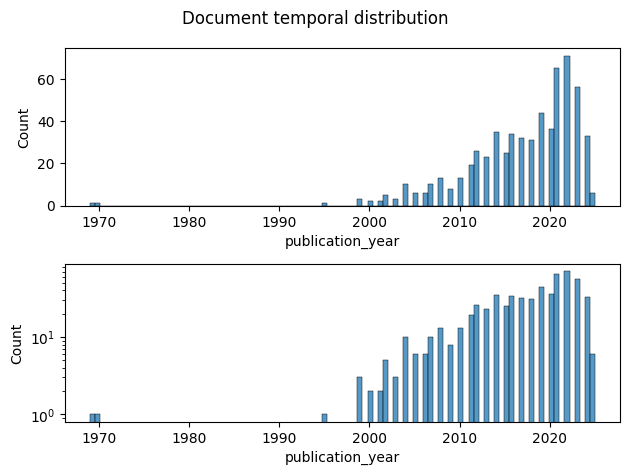

In [ ]:
fig, (ax0, ax1) = plt.subplots(2)
fig.suptitle("Document temporal distribution")
sns.histplot(df_documents['publication_year'], ax=ax0, bins=100)
sns.histplot(df_documents['publication_year'], log=True, bins=100, ax=ax1)
fig.tight_layout()

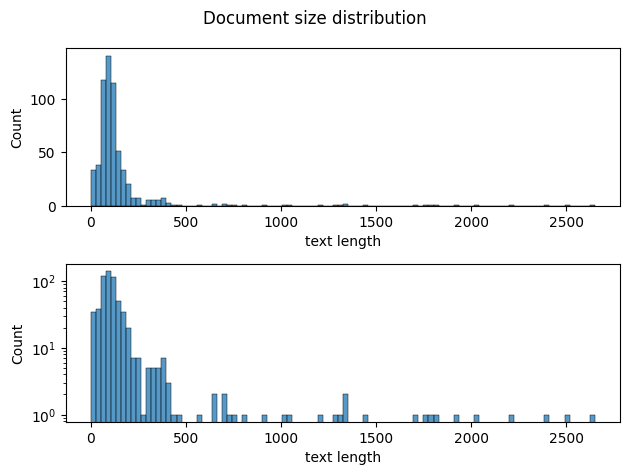

In [ ]:
document_lengths = tokens.map(len).rename('text length')
fig, (ax0, ax1) = plt.subplots(2)
fig.suptitle('Document size distribution')
sns.histplot(document_lengths, ax=ax0, bins=100)
sns.histplot(document_lengths, log=True, bins=100, ax=ax1)
fig.tight_layout()

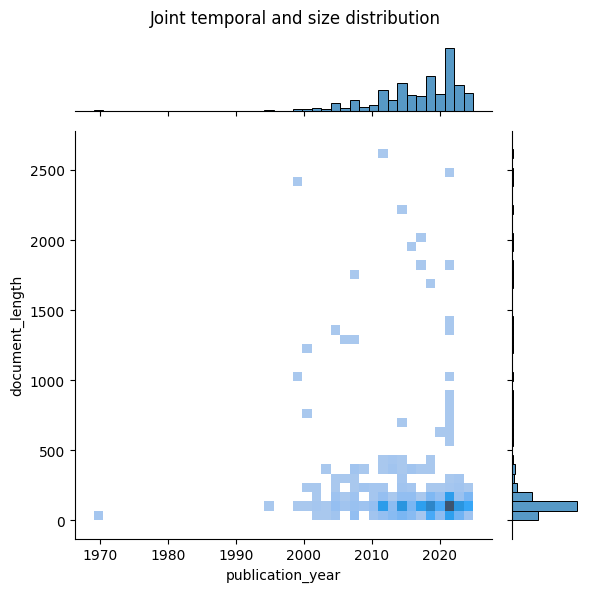

In [ ]:
ax = sns.jointplot(
    df_documents.assign(document_length=document_lengths),
    x='publication_year',
    y='document_length',
    kind='hist',
    bins=(40, 40),
)
ax.figure.suptitle('Joint temporal and size distribution')
ax.figure.tight_layout()

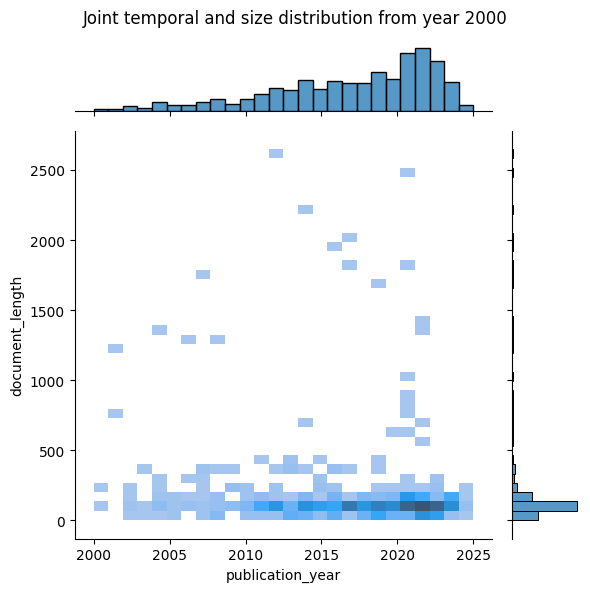

In [ ]:
ax = sns.jointplot(
    df_documents[
        lambda df: df['publication_year'].ge(2000)
    ].assign(document_length=document_lengths),
    x='publication_year',
    y='document_length',
    kind='hist',
    bins=(26, 40),
)
ax.figure.suptitle('Joint temporal and size distribution from year 2000')
ax.figure.tight_layout()

One can see there's an explosion of longer abstracts in recent years. Maybe we should investigate that?

Let's see the rows with abstracts longer than a thousand characters.

In [ ]:
df_documents[lambda df: document_lengths.ge(1000)]

id  \
1420  https://openalex.org/W2604030660   
4858  https://openalex.org/W4244542005   
4867  https://openalex.org/W2925112262   
4885  https://openalex.org/W1970810401   
5214  https://openalex.org/W2170477375   
5257  https://openalex.org/W3118292497   
5372  https://openalex.org/W3106915928   
5570  https://openalex.org/W2461337736   
5654  https://openalex.org/W4239014694   
5675  https://openalex.org/W2210695183   
5677  https://openalex.org/W3112555115   
5682  https://openalex.org/W4251674419   
5683  https://openalex.org/W3103779838   
5686  https://openalex.org/W4226441549   
5687  https://openalex.org/W4226110373   
5688  https://openalex.org/W3189107656   
5690  https://openalex.org/W2891313029   
5692    https://openalex.org/W38147484   

                                             doi  \
1420            https://doi.org/10.5204/mcj.1202   
4858            https://doi.org/10.5204/mcj.1762   
4867        https://doi.org/10.1162/daed_a_01738   
4885   https://doi.org/10.1080/03007760802053104   
5214             https://doi.org/10.5204/mcj.912   
5257            https://doi.org/10.5204/mcj.2643   
5372            https://doi.org/10.5204/mcj.2427   
5570            https://doi.org/10.5204/mcj.1100   
5654   https://doi.org/10.1525/jpms.2021.33.3.55   
5675             https://doi.org/10.5204/mcj.462   
5677            https://doi.org/10.5204/mcj.1900   
5682  https://doi.org/10.1525/jpms.2021.33.3.213   
5683            https://doi.org/10.5204/mcj.2617   
5686   https://doi.org/10.1525/jpms.2022.34.1.29   
5687    https://doi.org/10.1525/jpms.2022.34.1.4   
5688          https://doi.org/10.1111/jpcu.13050   
5690            https://doi.org/10.5204/mcj.1361   
5692            https://doi.org/10.5204/mcj.1805   

                                                  title  \
1420  Mix En Meng It Op: Emile YX?'s Alternative Rac...   
4858                                    Justify My Love   
4867                             Why Jazz Still Matters   
4885  The Englishness of English Punk: Sex Pistols, ...   
5214   Articulating the "Counter" in Subculture Studies   
5257                                   Becoming-Samurai   
5372        'Australian Idol' and the Attention Economy   
5570  Place, Space, and Time in MC Solaar’s American...   
5654                                Phonography Culture   
5675  Oh Blessed Holy Caffeine Tree: Coffee in Popul...   
5677                                Mixing with Records   
5682                                Contributors’ Notes   
5683  Off World Sounds: Building a Collaborative Sou...   
5686                           Rock Trolls and Recovery   
5687                           Music for Counting Votes   
5688  The Death and Resurrection of Oshun in Beyoncé...   
5690  ‘Southern’ Northern Soul: Changing Senses of D...   
5692                         'This Machine Is Obsolete'   

                                           display_name  relevance_score  \
1420  Mix En Meng It Op: Emile YX?'s Alternative Rac...        85.982710   
4858                                    Justify My Love         5.341688   
4867                             Why Jazz Still Matters         5.087096   
4885  The Englishness of English Punk: Sex Pistols, ...         3.907446   
5214   Articulating the "Counter" in Subculture Studies         2.246151   
5257                                   Becoming-Samurai         2.129181   
5372        'Australian Idol' and the Attention Economy         1.919123   
5570  Place, Space, and Time in MC Solaar’s American...         1.342277   
5654                                Phonography Culture         0.783903   
5675  Oh Blessed Holy Caffeine Tree: Coffee in Popul...         0.586010   
5677                                Mixing with Records         0.551731   
5682                                Contributors’ Notes         0.502061   
5683  Off World Sounds: Building a Collaborative Sou...         0.490798   
5686                           Rock Trolls and Recovery       

And let's take a look at some of these very long abstracts.

In [ ]:
df_documents[document_lengths >= 1000]["abstract"].reset_index(drop=True).iloc[0]

'This paper explores South African hip-hop activist Emile YX?\'s work to suggest that he presents an alternative take on mainstream US and South African hip-hop. While it is arguable that a great deal of mainstream hip-hop is commercially co-opted, it is clear that a significant amount of US hip-hop (by Angel Haze or Talib Kweli, for example) and hip-hop beyond the US (by Positive Black Soul, Godessa, Black Noise or Prophets of da City, for example) present alternatives to its co-option. Emile YX? pushes for an alternative to mainstream hip-hop\'s aesthetics and politics. Foregoing what Prophets of da City call “mindless topics” (Prophets of da City “Cape Crusader”), he employs hip-hop to engage audiences critically about social and political issues, including language and racial identity politics. Significantly, he embraces AfriKaaps, which is a challenge to the hegemonic speech variety of Afrikaans. From Emile\'s perspective, AfriKaaps preceded Afrikaans because it was spoken by slav

In [ ]:
df_documents[document_lengths >= 1000]["abstract"].reset_index(drop=True).iloc[1]

'In the past two decades a number of new disciplines (cultural studies, media studies, gender studies, women\'s studies, etc.) have established themselves within the academy. They have often been developed from an overtly radical political stance and set out to challenge entrenched ways of thinking about the world and the society we live in. They transgress academic norms by bringing under academic scrutiny things (film, popular music, computer games, etc.) that, in the past, would have been seen as unimportant and unworthy of critical attention. Basically, these new disciplines have provided a space in which to take popular culture seriously in a way that was difficult, if not impossible, within more traditional academic disciplines. By doing so they have also opened up the more traditional disciplines so that musicologists, for example, can now write about Led Zeppelin (Headlam) and professors of philosophy and of English can write learned works about Madonna (Bordo, Kaplan). They ha

After inspecting the results, we conclude that many documents are not abstracts, but the full article text or a part of it.
This poses a problem, making the texts less homogeneous and thus less amenable to being analyzed together.
We will deal with this issue later, after identifying another issue.

# Checking frequency and presence

Let's start to work with the statistics of terms in our corpus, where the most fundamental things to consider are term presence and term frequency.

Given a token and a document:
- Presence is whether or not the token appears in the document. That is, `any(token==t for t in document)` or simply `token in document`.
- Frequency is how many times the token appears in the document. That is, `sum(token==t for t in document)`.

What are most frequent and most present terms in our corpus?

Because the values in the 'tokens' column of our `DataFrame` are lists of words, we can't directly apply `value_counts()` to get the counts of individual words.
We must first call `explode()` on the 'tokens' column to obtain a new `Series` where elements become individual words. That is, `explode()` turns:

```
Series([["the", "first", "document"], ["the", "second", "document"]])
```

into

```
Series(["the", "first", "document", "the", "second", "document"])
```

So that `value_counts()` will count the number of ocurrences of each word in the corpus.

In [ ]:
frequency = df_documents['tokens'].explode().value_counts().rename('frequency')

frequency.iloc[:20]

tokens
hip         1952
hop         1940
music       1497
culture      706
rap          632
de           603
black        575
cultural     475
popular      403
new          396
social       386
musical      332
american     305
article      291
artists      275
studies      268
african      264
identity     244
e            225
research     216
Name: frequency, dtype: int64

Interestingly, we see a lot of English stop words there! Which of course weren't removed since we used the Spacy rules-based model for French. This means our French corpus is contaminated with English text! And perhaps other lanugages as well. This is pretty bad, since it can distort our analyses. Again, we shall investigate it!

In [ ]:
print(df_documents.columns)

Index(['id', 'doi', 'title', 'display_name', 'relevance_score',
       'publication_year', 'publication_date', 'language', 'type',
       'type_crossref',
       ...
       'grants.funder_display_name', 'grants.award_id',
       'institution_assertions.id', 'institution_assertions.display_name',
       'institution_assertions.ror', 'institution_assertions.country_code',
       'institution_assertions.type', 'institution_assertions.lineage', 'text',
       'tokens'],
      dtype='object', length=183)


In [ ]:
df_documents['tokens'] = df_documents['abstract'].astype(str).str.lower().str.split()

In [ ]:
df_documents.loc[
    lambda df: df['tokens'].map(lambda row: 'from' in row),
    'abstract'
].iloc[
    # Change the location below to inscpect different documents
    0
]

"Background/Context Over the past 5 years, there has been a growing body of scholarship that examines the intersections of hip-hop culture and classroom pedagogy. Although recent scholarship has persuasively demonstrated the classroom potential of hip-hop texts for promoting student engagement, scaffolding sanctioned forms of knowledge, and nurturing critical consciousness and activism, little work has been done to unpack the complex relations of power that emerge in such classrooms. In particular, we know very little about the ways in which students and teachers are (re)positioned within classrooms that engage in hip-hop-centered pedagogy. This article contributes to the current literature in hip-hop based education, culturally relevant pedagogy, and critical pedagogy by examining the some of the issues and tensions that emerge when teachers engage in hip-hop-centered classroom pedagogy. Purpose/Objective/Research Question/Focus of Study This study details how the articulation of pers

Our text starts with the document title, in French, but then continues with an abstract in English followed by the same abstract in French.
So not only the abstract contains a foreign language, but it appears in double, which impacts the length of our text.

# Cleaning up for language and length

We first try to get rid of English text, because it impacts the length. Then we'll figure out a size threshold to consider an abstract valid.

We start by building the language detector.

In [ ]:
languages = [
    lingua.Language.ENGLISH,
    lingua.Language.FRENCH,
    lingua.Language.GERMAN,
    lingua.Language.SPANISH
]
language_detector = lingua.LanguageDetectorBuilder.from_languages(*languages).build()

Then we rebuild our tokens from the column 'text' by testing the language of each sentence and discarding those not detected as French.

To iterate over sentences, we take advantage of the `sent` attribute of the Spacy document.

However, for the rules-based model to set sentece boundaries, we'll have to first recreate our Spacy documents after adding the 'sentencizer' to the model's pipeline.

In [ ]:
nlp_rb = spacy.blank('en')
nlp_rb.add_pipe('sentencizer')

docs_rb = df_documents['abstract'].map(nlp_rb)

In [ ]:
sr_english_sentences = docs_rb.map(
    lambda doc: [
        sent
        for sent in doc.sents
        if (language_detector.detect_language_of(sent.text) == lingua.Language.ENGLISH)
    ]
)

Reconstruct the text by concatenating the French language sentences.

In [ ]:
text = sr_english_sentences.map(lambda sents: ' '.join([str(sent) for sent in sents]))
df_documents['abstract'] = text

Produce the new tokens to check for document length.

In [ ]:
tokens = sr_english_sentences.map(
    lambda sents: [
        token.norm_
        for sent in sents
        for token in sent
        if not (token.is_punct or token.is_stop or token.like_num)
    ]
)

display_tokens(tokens.iloc[0])

'lucrative | popular | culturally | oppositional | musical | force | united | states | hip | hop | demands | kind | interpretation | imani | perry | provides | criticism | engaged | vibrant | musical | form | terms | scholar | fan | perry | considers | art | politics | culture | hip | hop | analysis | song | lyrics | words | prophets | hood | recognizing | prevailing | characterizations | hip | hop | transnational | musical | form | perry | advances | powerful | argument | hip | hop | foremost | black | american | music | time | contends | studies | shortchanged | aesthetic | value | rap | attributing | form | content | primarily | socioeconomic | factors | innovative | analysis | revels | artistry | hip | hop | revealing | art | innovation | deprivation | \n\n | perry | offers | detailed | readings | lyrics | hip | hop | artists | including | ice | cube | public | enemy | de | la | soul | krs | outkast | sean | puffy | combs | tupac | shakur | lil | kim | biggie | smalls | nas | metho

We update the `DataFrame` from which we got the texts with the improved textual tokens.

In [ ]:
df_documents['tokens'] = tokens

Let's check the new distribution of document sizes and some sample documents of different sizes.

In [ ]:
document_lengths = tokens.map(len).rename('text length')

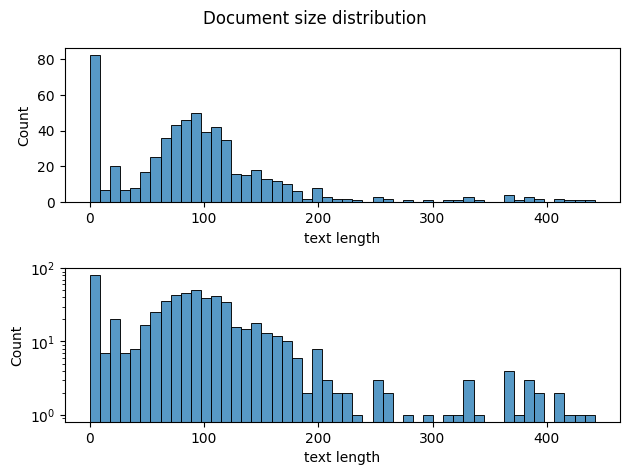

In [ ]:
fig, (ax0, ax1) = plt.subplots(2)
fig.suptitle('Document size distribution')
sns.histplot(document_lengths[lambda sr: sr.le(500)], ax=ax0, bins=50)
sns.histplot(document_lengths[lambda sr: sr.le(500)], log=True, bins=50, ax=ax1)
fig.tight_layout()

In [ ]:
df_documents[
    # Change these numbers to sample documents of different sizes
    lambda df: document_lengths.ge(300) & document_lengths.le(400)
][
    "abstract"
].sample().squeeze()

'Rhetoric of Reputation: Protagoras’ Statement, Snoop Doggy Dogg’s Flow SPENCER HAWKINS Reputation can decide our station in life, and it is so often out of our control. This anxiety-inducing situation can leave us obsessed with the project of controlling our reputations. Contemporary hip hop and ancient Greek sophistry have enjoyed immense success by responding to this desperate obsession, among American teenagers and among politically ambitious, litigious ancient Greeks, respectively. Both systems propose means to control the kind of impression we make on others. These discourses of self-promotion train people to take their status into their own hands, to represent themselves whether in song and banter, or in court and assembly speeches. I compare these two kinds of rhetoric on several bases: their commercial success, cultural impact, shared individualistic ethos, and the moral outrage that their expressed attitudes provoked. The difference between aesthetic and rationalistic discour

From a closer inspection of the distribution, as well as reading a few sample abstracts, we guess that discarding abstracts above 400 tokens should rid our corpus of the bad cases while preserving the bulk of the corpus.

In [ ]:
print('Number of documents before: ', len(df_documents))
df_documents = df_documents[lambda df: document_lengths.le(400)]
print('Number of documents after: ', len(df_documents))

Number of documents before:  620
Number of documents after:  588


The new cleaned corpus is now a reasonable basis to carry on our analyses.

# Modeling

As we'll be processing textual data with language models, let's make sure we always store the results and load them from disk instead of reprocessing each time we run the notebook.

In [ ]:
def get_docs_try_pickled(*, sr_text, nlp_model, pickle_path):
    pickle_path = Path(pickle_path)
    pickle_path.parent.mkdir(exist_ok=True)
    pickle_path = pickle_path.with_stem(f'{pickle_path.stem} @len:{len(sr_text)}')
    try:
        # Read from pickled data if it exists
        docs = pd.read_pickle(pickle_path)
    except Exception as e:
        if input(
            f"Could not find pickle, shall we process all {len(sr_text)} documents?\n"
            "(May take a long time if you did not pick a sample.)\n"
            "Answer with Y or N: "
        ) != "Y":
            raise e
        docs = sr_text.map(nlp_model).rename('docs')
        # Store a pickle so next time we load that instead of processing everything again.
        docs.to_pickle(pickle_path)
    return docs

Obtain Spacy documents, using a richer language model capable of part-of-speech tagging.

In [ ]:
!spacy download en_core_web_trf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.4/457.4 MB 3.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
!spacy info en_core_web_trf


=================== Info about pipeline 'en_core_web_trf' ===================

lang                en                            
name                core_web_trf                  
version             3.8.0                         
description         English transformer pipeline (Transformer(name='roberta-base', piece_encoder='byte-bpe', stride=104, type='roberta', width=768, window=144, vocab_size=50265)). Components: transformer, tagger, parser, ner, attribute_ruler, lemmatizer.
author              Explosion                     
email               contact@explosion.ai          
url                 https://explosion.ai          
license             MIT                           
spacy_version       >=3.8.0,<3.9.0                
spacy_git_version   5010fcbd3                     
vectors             {'width': 0, 'vectors': 0, 'keys': 0, 'name': None}
pipeline            ['transformer', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']
components          ['transformer', 't

In [ ]:
import spacy
print(spacy.__version__)

3.8.7


In [ ]:
import spacy

nlp_trf = spacy.load("en_core_web_trf")


In [ ]:
all_docs = get_docs_try_pickled(
    sr_text=df_documents['abstract'],
    nlp_model=nlp_trf,
    pickle_path=OUTPUT_SPACY_DOCUMENTS_EN_DEP_NEWS_TRF,
)

In [ ]:
all_docs

2       (At, once, the, most, lucrative, ,, popular, ,...
53      (Yancy, ,, Hadley, ,, Give, 'em,  , One, Mic, ...
74      (Background, /, Context, Over, the, past, 5, y...
76      (It, has, been, more, than, thirty, -, five, y...
96      (Hip, -, hop, ,, created, by, black, and, Lati...
                              ...                        
5573    (Rhetoric, of, Reputation, :, Protagoras, ’, S...
5591    (In, this, volume, ,, Tayin, Falola, and, Tyle...
5602    (<, JATS1, :p, >, African, Americans, ', histo...
5616    (The, Bloomsbury, 33⅓, series, of, album, mono...
5640    (Introduction, to, Critical, Forum, :, The, So...
Name: docs, Length: 588, dtype: object

We'll also need documents processed with spacy's "lg" model, which is capable of Named Entity Recognition (NER).

In [ ]:
OUTPUT_SPACY_DOCUMENTS_EN_CORE_WEB_MD = 'pickles/docs @sel:all @spacy:en_core_web_md.pickle'

In [ ]:
import spacy

# Télécharger le modèle si ce n’est pas déjà fait
!python -m spacy download en_core_web_md

# Charger le modèle
nlp_lg = spacy.load('en_core_web_md')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 20.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
docs_lg = get_docs_try_pickled(
    sr_text=df_documents['abstract'],
    nlp_model=nlp_lg,
    pickle_path=OUTPUT_SPACY_DOCUMENTS_EN_CORE_WEB_MD,
)

In [ ]:
docs_lg

2       (At, once, the, most, lucrative, ,, popular, ,...
53      (Yancy, ,, Hadley, ,, Give, 'em,  , One, Mic, ...
74      (Background, /, Context, Over, the, past, 5, y...
76      (It, has, been, more, than, thirty, -, five, y...
96      (Hip, -, hop, ,, created, by, black, and, Lati...
                              ...                        
5573    (Rhetoric, of, Reputation, :, Protagoras, ’, S...
5591    (In, this, volume, ,, Tayin, Falola, and, Tyle...
5602    (<, JATS1, :p, >, African, Americans, ', histo...
5616    (The, Bloomsbury, 33⅓, series, of, album, mono...
5640    (Introduction, to, Critical, Forum, :, The, So...
Name: docs, Length: 588, dtype: object

In [ ]:
import colorcet
import lingua
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import spacy

In [ ]:
INPUT_SOURCE_DATA = 'works-2025-06-26T20-54-21.csv'

INPUT_SPACY_DOCUMENTS_FR_DEP_NEWS_TRF = 'pickles/docs @sel:all @spacy:en_dep_news_trf @len:7237.pickle'

In [ ]:
df_original = pd.read_csv(INPUT_SOURCE_DATA, low_memory=False)

len(df_original)

5694

In [ ]:
INPUT_SPACY_DOCUMENTS_EN_DEP_NEWS_TRF = "/content/pickles/docs @sel:all @spacy:en_core_web_md @len:588.pickle"


In [ ]:
all_docs_trf = pd.read_pickle(INPUT_SPACY_DOCUMENTS_EN_DEP_NEWS_TRF)

In [ ]:
df_documents = df_original.loc[all_docs_trf.index]

len(df_documents)

588

In [ ]:
# Uncomment the following line to work with only the first 100 documents
#df_documents = df_documents.iloc[:100]

# Uncomment the following line to work with a sample of 100 documents
#df_documents = df_documents.sample(100)

len(df_documents)

588

In [ ]:
df_documents = df_documents.copy()

In [ ]:
tokens = all_docs_trf.map(
    lambda doc: [
        token.norm_
        for token in doc
        if not (token.is_punct or token.is_stop or token.like_num)
    ]
)

In [ ]:
frequency = tokens.explode().value_counts().rename('frequency')

frequency.iloc[:20]

docs
hop          1604
hip          1597
music         978
culture       462
rap           447
black         355
cultural      327
article       254
social        239
popular       239
artists       213
musical       207
new           201
american      198
african       184
identity      175
paper         167
research      160
genre         159
political     154
Name: frequency, dtype: int64

In [ ]:
presence = tokens.map(set).explode().value_counts().rename('presence')

presence.iloc[:20]

docs
hip          480
hop          479
music        326
culture      230
cultural     186
article      173
rap          152
social       145
black        138
artists      131
new          126
popular      125
analysis     119
american     108
musical      108
paper        108
study        105
research     102
genre         96
political     94
Name: presence, dtype: int64

In [ ]:
df_word_stats = pd.concat(
    [presence, frequency],
    axis=1
)

df_word_stats['freq_pres_ratio'] = frequency.div(presence).rename('freq_pres_ratio')

df_word_stats.sort_values(by='freq_pres_ratio', ascending=False).iloc[:20]



presence  frequency  freq_pres_ratio
docs                                                  
degrading                1         16             16.0
                         5         73             14.6
davis                    1         12             12.0
afro-­‐colombian         1         11             11.0
hip-­‐hop                1         11             11.0
fat                      1         10             10.0
fatness                  1         10             10.0
mathes                   1         10             10.0
jihadi                   1          9              9.0
irish                    1          9              9.0
bachata                  1          8              8.0
betty                    1          8              8.0
search                   5         38              7.6
turkish                  2         15              7.5
hh                       1          7              7.0
verdean                  1          7              7.0
sophist                  1          7              7.0
t                        1          7              7.0
sofer                    1          7              7.0
roma                     1          7              7.0

In [ ]:
df_word_stats['presence_rel'] = df_word_stats['presence'].div(len(df_documents))

df_word_stats['specificity'] = (
    df_word_stats['freq_pres_ratio']
    .mul(
        df_word_stats['presence_rel'].ge(0.05)
#        & df_word_stats['presence_rel'].le(0.5)
    )
)

df_word_stats.sort_values(by=['specificity', 'presence'], ascending=False).iloc[:30]



presence  frequency  freq_pres_ratio  presence_rel  specificity
docs                                                                         
hop                479       1604         3.348643      0.814626     3.348643
hip                480       1597         3.327083      0.816327     3.327083
music              326        978         3.000000      0.554422     3.000000
rap                152        447         2.940789      0.258503     2.940789
women               45        129         2.866667      0.076531     2.866667
black              138        355         2.572464      0.234694     2.572464
african             87        184         2.114943      0.147959     2.114943
pop                 30         63         2.100000      0.051020     2.100000
culture            230        462         2.008696      0.391156     2.008696
musical            108        207         1.916667      0.183673     1.916667
popular            125        239         1.912000      0.212585     1.912000
university          30         57         1.900000      0.051020     1.900000
digital             30         57         1.900000      0.051020     1.900000
identity            93        175         1.881720      0.158163     1.881720
rappers             50         93         1.860000      0.085034     1.860000
white               38         70         1.842105      0.064626     1.842105
american           108        198         1.833333      0.183673     1.833333
studies             85        152         1.788235      0.144558     1.788235
cultural           186        327         1.758065      0.316327     1.758065
authenticity        39         68         1.743590      0.066327     1.743590
youth               68        116         1.705882      0.115646     1.705882
songs               61        104         1.704918      0.103741     1.704918
country             33         56         1.696970      0.056122     1.696970
art                 67        113         1.686567      0.113946     1.686567
sexual              30         50         1.666667      0.051020     1.666667
genre               96        159         1.656250      0.163265     1.656250
social             145        239         1.648276      0.246599     1.648276
political           94        154         1.638298      0.159864     1.638298
urban               58         95         1.637931      0.098639     1.637931
sound               43         70         1.627907      0.073129     1.627907

In [ ]:
interesting_words = {
    'hop', 'hip', 'music', 'rap', 'women', 'black',
    'african', 'pop', 'culture', 'musical', 'popular',
    'university', 'digital', 'identity', 'rappers',
    'white', 'american', 'studies', 'cultural',
    'authenticity', 'youth', 'songs', 'country',
    'art', 'sexual', 'genre', 'social', 'political',
    'urban', 'sound',
}

In [ ]:
def count_cooccurrences(this_series, other_series, this_elements, other_elements):
    """
    Counts cooccurrences of elements between sequences in `this_series` and `other_series`.
    If both series are the same, this is the usual "singular" cooccurrence.

    Note that both series must contain sequences, thus if your values are singular you must first wrap them in a list.
    """
    breakpoint()
    # Make sure elements are `set`s for performance
    this_elements, other_elements = set(this_elements), set(other_elements)
    # Create a `DataFrame` from both `Series`,
    # Keep only the words from the corresponding elements,
    # Apply `set` so words only appear once.
    this_and_other = pd.DataFrame(
        {
            'this': this_series.map(lambda sequence: set(element for element in sequence if element in this_elements)),
            'other': other_series.map(lambda sequence: set(element for element in sequence if element in other_elements)),
        }
    )
    # Explode sequences `[a,b,c]` to count their elements `a,b,c`
    cooccurrence_counts = this_and_other.explode('this').explode('other').value_counts()
    # We have counts as a `Series` with indices `(a,b)`, but we want a DataFrame where `a` is the index and `b` is the colum
    cooccurrence_counts = cooccurrence_counts.unstack('other')
    # Finally, as a matrix our `DataFrame` contains all combinations, so we set those that did not appear in the `Series` to `0`
    cooccurrence_counts = cooccurrence_counts.fillna(0).astype(int)
    return cooccurrence_counts

In [ ]:
cooccurrence_counts = count_cooccurrences(tokens, tokens, interesting_words, interesting_words)

cooccurrence_counts


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.11/bdb.py", line 336, in set_trace
    sys.settrace(self.trace_dispatch)



> /tmp/ipython-input-66-2222807166.py(10)count_cooccurrences()
      8     breakpoint()
      9     # Make sure elements are `set`s for performance
---> 10     this_elements, other_elements = set(this_elements), set(other_elements)
     11     # Create a `DataFrame` from both `Series`,
     12     # Keep only the words from the corresponding elements,

ipdb> Y
*** NameError: name 'Y' is not defined
ipdb> Y
*** NameError: name 'Y' is not defined



PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.11/bdb.py", line 361, in set_quit
    sys.settrace(None)


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/debugger.py", line 1075, in cmdloop
    sys.settrace(None)



--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user


other         african  american  art  authenticity  black  country  cultural  \
this                                                                           
african            87        63   18             7     44       10        45   
american           63       108   24             7     57        8        55   
art                18        24   67             6     25        2        28   
authenticity        7         7    6            39     13        2        19   
black              44        57   25            13    138        4        61   
country            10         8    2             2      4       33        16   
cultural           45        55   28            19     61       16       186   
culture            56        75   43            23     77       18       111   
digital             1         2    5             2      4        0        10   
genre              16        23   15            12     29        8        31   
hip                84       105   65            39    133       31       178   
hop                84       105   64            39    133       31       178   
identity           20        20    8             7     33        8        44   
music              66        79   49            31     91       23       128   
musical            24        32   19            11     27        8        44   
political          21        24   14             3     29       10        58   
pop                 1         4    4             4      2        4        12   
popular            29        42   24            13     41       14        55   
rap                32        45   23            17     45        8        65   
rappers             3        12    5             6     15        1        22   
sexual              7         7    4             0     14        2        12   
social             23        32   17            10     40       10        76   
songs              10        14    8             1     19        6        21   
sound               8         8    8             5     15        1        13   
studies            12        21   13             6     21        5        44   
university          8        13    7             2      7        3        12   
urban               9        11   10             4     18        2        22   
white              10        14   12             5     25        2        16   
women              16        15    7             1     25        0        19   
youth              18        20   14             6     29        5        35   

other         culture  digital  genre  ...  sexual  social  songs  sound  \
this                                   ...                                 
african            56        1     16  ...       7      23     10      8   
american           75        2     23  ...       7      32     14      8   
art                43        5     15  ...       4      17      8      8   
authenticity       23        2     12  ...       0      10      1      5   
black              77        4     29  ...      14      40     19     15   
country            18        0      8  ...       2      10      6      1   
cultural          111       10     31  ...      12      76     21     13   
culture           230       13     44  ...      12      80     22     22   
digital            13       30      5  ...       1      10      2      5   
genre              44        5     96  ...       7      31     18     11   
hip               226       28     93  ...      29     140     60     42   
hop               225       27     93  ...      29     140     60     42   
identity           46        3     26  ...       7      28     11      7   
music             150       24     78  ...      26      94     47     35   
musical            55        8     36  ...       6      40     21     16   
political          47        3     19  ...       4      44     10     11   
pop                12        5      7  ...       4       7      8      

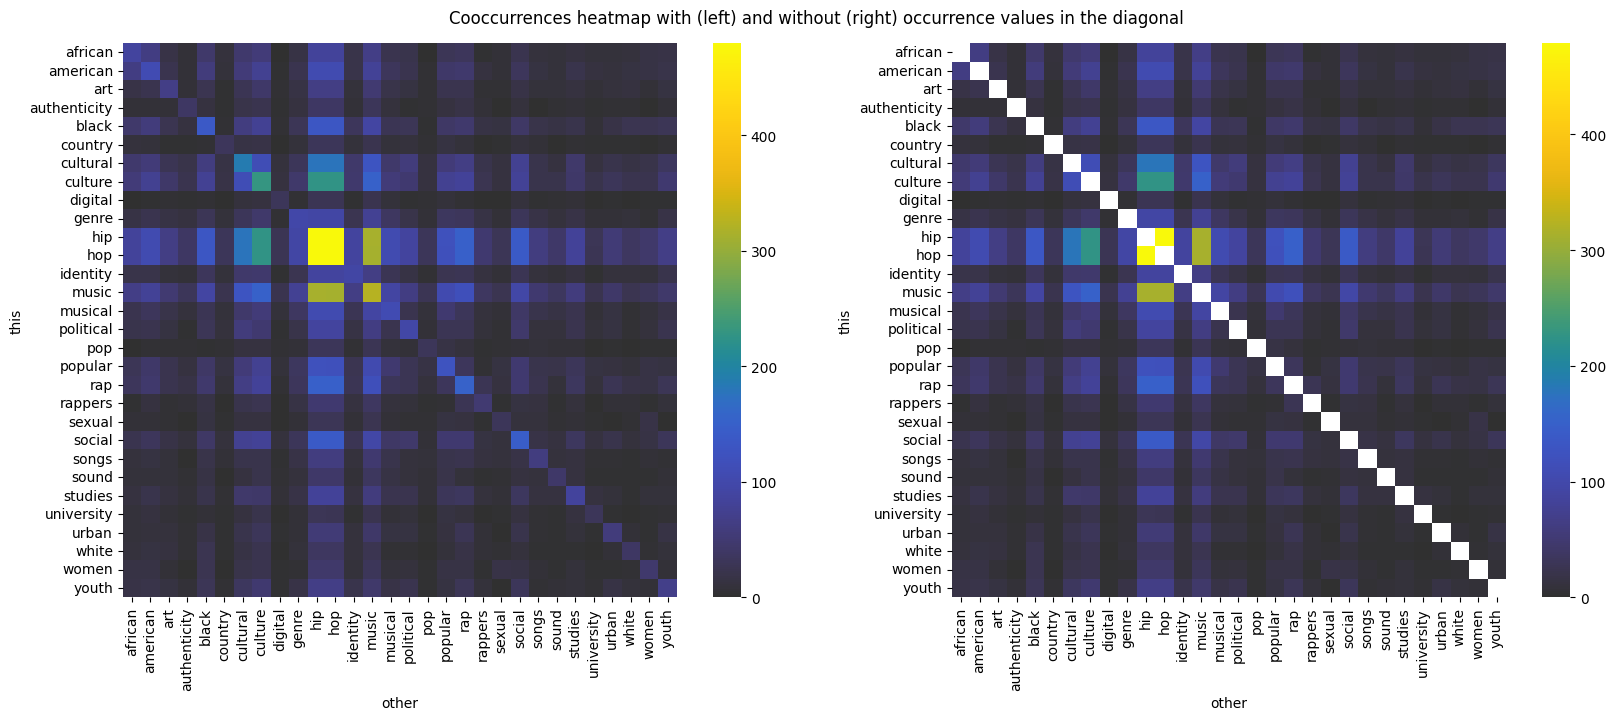

In [ ]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(17, 7))
fig.suptitle("Cooccurrences heatmap with (left) and without (right) occurrence values in the diagonal")
axes = sns.heatmap(
    cooccurrence_counts,
    cmap=colorcet.linear_kbgoy_20_95_c57,
    square=True,
    ax=ax0,
)
axes = sns.heatmap(
    cooccurrence_counts,
    cmap=colorcet.linear_kbgoy_20_95_c57,
    square=True,
    mask=np.identity(len(cooccurrence_counts)), # Mask the diagonal
    ax=ax1,
)
fig.tight_layout()

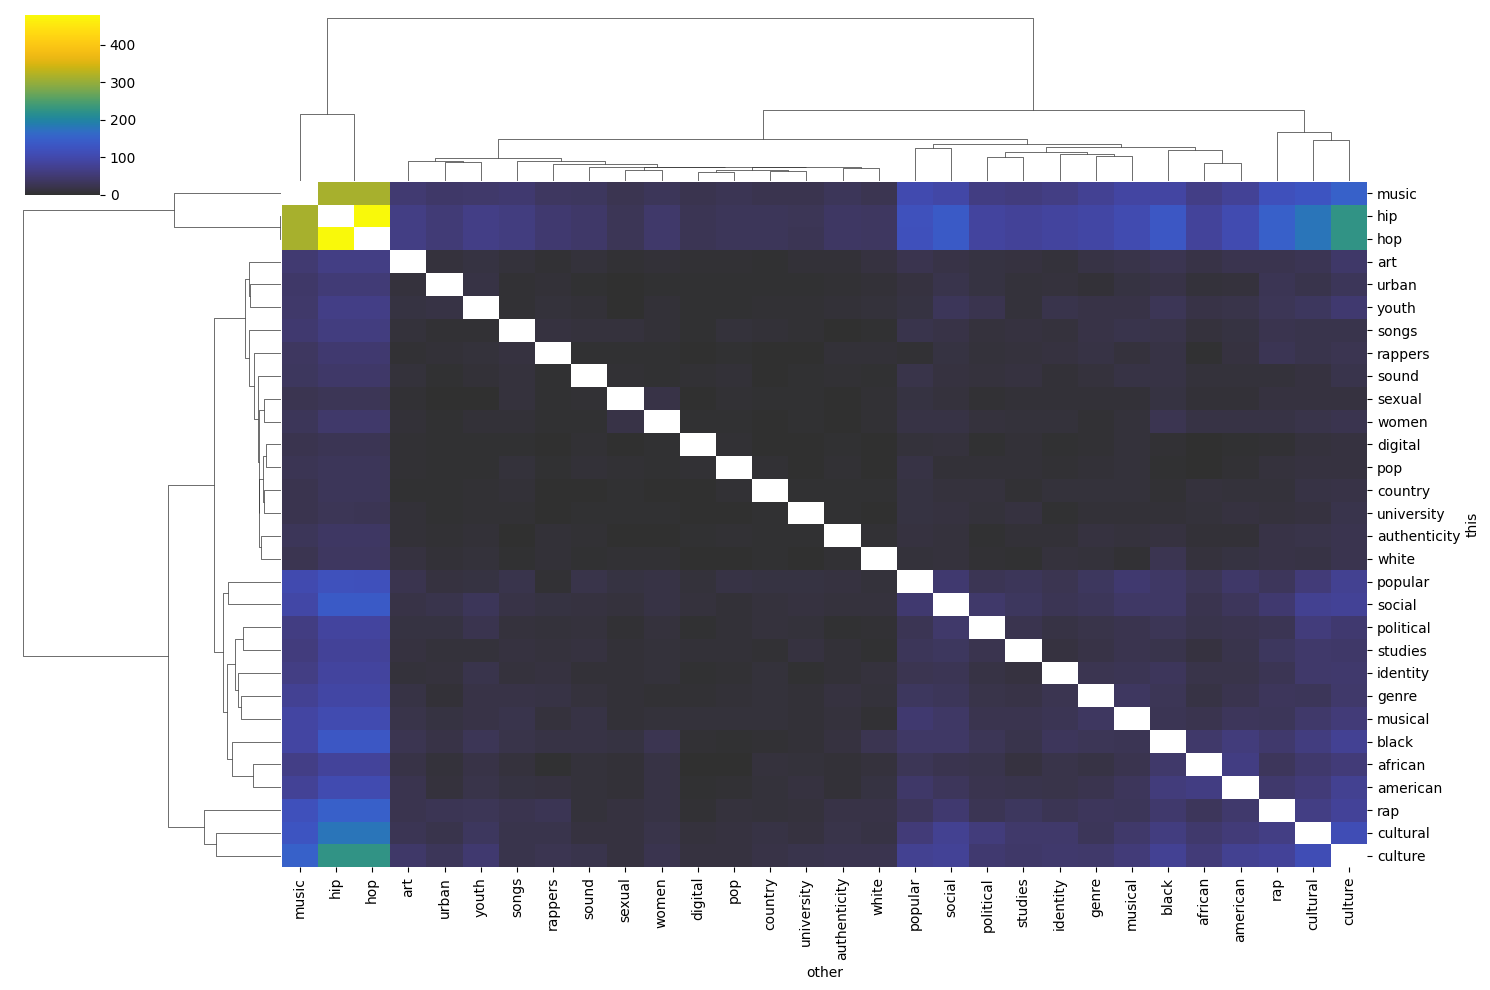

In [ ]:
axes = sns.clustermap(
    cooccurrence_counts,
    method='average',
    cmap=colorcet.linear_kbgoy_20_95_c57,
    figsize=(15, 10),
    mask=np.identity(len(cooccurrence_counts)) # Mask the diagonal since it contains occurrence values, which being stronger would hinder the color scale
)

In [ ]:
# We divide each row (`axis=0`) by the occurrence of its word so that it represents the fraction of occurrences of that word that cooccurr with the word for the column.
occurrence_count = cooccurrence_counts.values.diagonal()
conditional_cooccurrence = cooccurrence_counts.div(occurrence_count, axis=0)

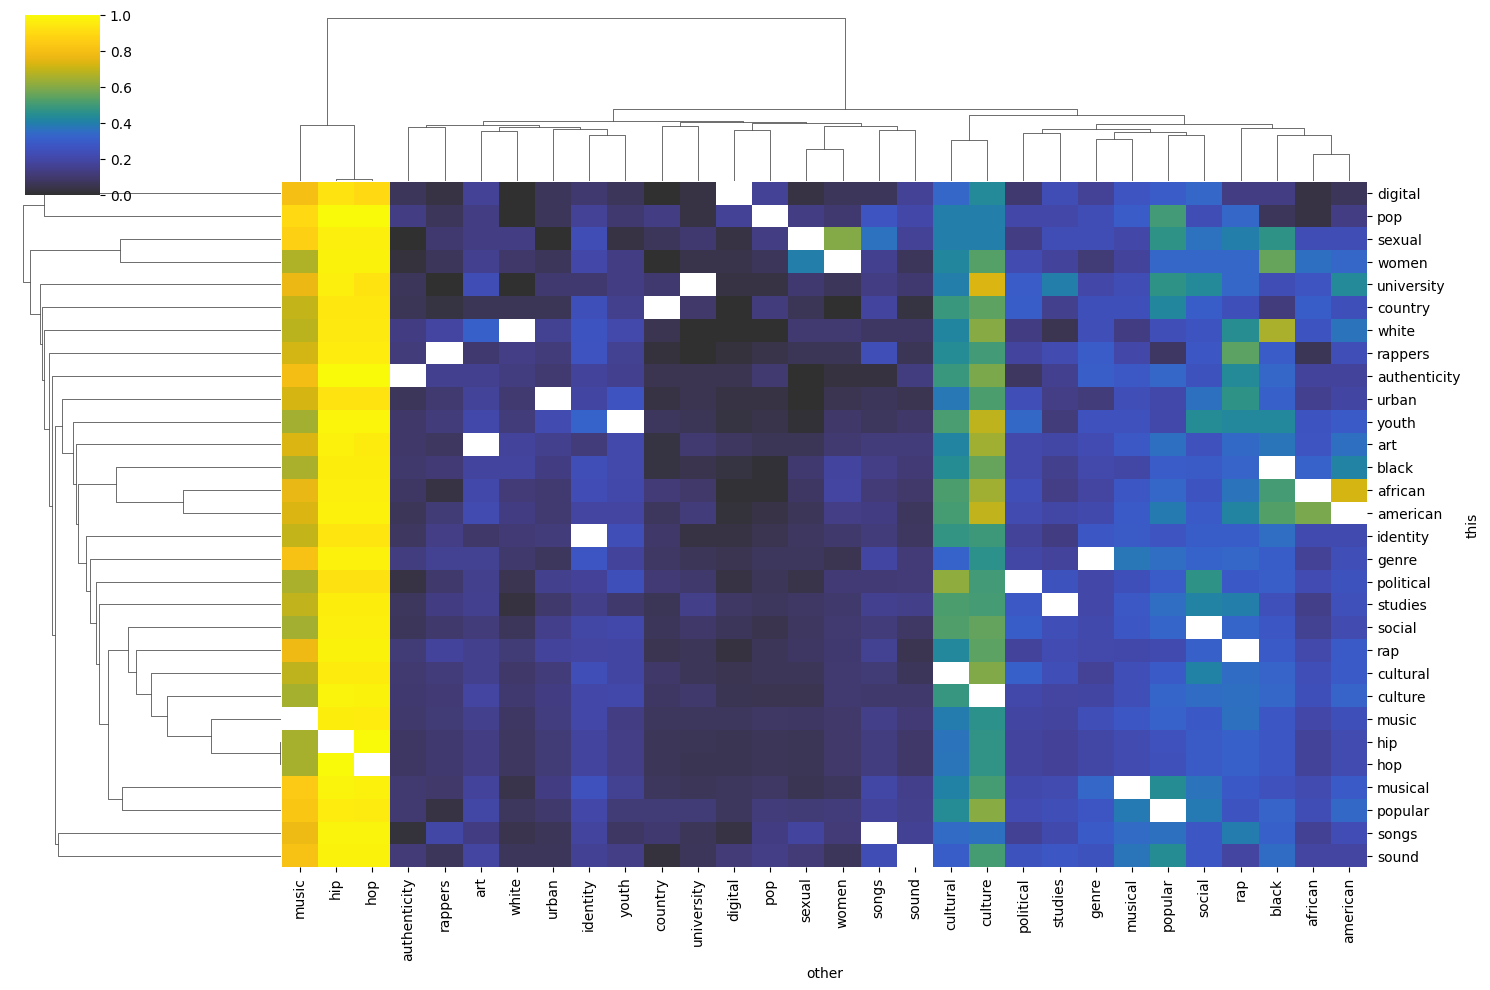

In [ ]:
axes = sns.clustermap(conditional_cooccurrence, method='average', cmap=colorcet.linear_kbgoy_20_95_c57, figsize=(15, 10), mask=np.identity(len(conditional_cooccurrence)))

In [ ]:
paratextual_column = 'primary_location.source.display_name'

paratextual_counts = df_documents[paratextual_column].value_counts()

paratextual_counts.iloc[:10]

primary_location.source.display_name
Global Hip Hop Studies                                                   30
Volume !                                                                 16
Popular Music                                                            13
Journal of Popular Music Studies                                         12
IASPM Journal                                                            11
Critical Studies in Improvisation / Études critiques en improvisation     8
Music Theory Online                                                       6
Dancecult                                                                 6
Routledge eBooks                                                          6
Duke University Press eBooks                                              6
Name: count, dtype: int64

In [ ]:
paratextual_elements = paratextual_counts.iloc[:20].index

In [ ]:
paratextual_series_as_sequence = df_documents[paratextual_column].map(lambda x: [x])

In [ ]:
paratextual_cooccurrence_counts = count_cooccurrences(tokens, paratextual_series_as_sequence, interesting_words, paratextual_elements)

paratextual_cooccurrence_counts

> /tmp/ipython-input-66-2222807166.py(10)count_cooccurrences()
      8     breakpoint()
      9     # Make sure elements are `set`s for performance
---> 10     this_elements, other_elements = set(this_elements), set(other_elements)
     11     # Create a `DataFrame` from both `Series`,
     12     # Keep only the words from the corresponding elements,

--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user


other         African Studies Review  Arts  Choice Reviews Online  \
this                                                                
african                            1     1                      3   
american                           0     1                      4   
art                                0     5                      3   
authenticity                       0     0                      0   
black                              0     2                      2   
country                            0     0                      0   
cultural                           0     3                      3   
culture                            0     4                      4   
digital                            0     1                      0   
genre                              0     0                      0   
hip                                1     5                      5   
hop                                1     5                      5   
identity                           0     0                      0   
music                              2     2                      4   
musical                            0     0                      3   
political                          0     2                      2   
pop                                0     0                      1   
popular                            1     1                      4   
rap                                0     1                      2   
rappers                            0     0                      0   
sexual                             0     0                      0   
social                             1     1                      2   
songs                              0     0                      1   
sound                              0     0                      1   
studies                            0     0                      3   
university                         2     0                      1   
urban                              1     1                      0   
white                              0     1                      0   
women                              0     1                      0   
youth                              0     0                      0   

other         Critical Studies in Improvisation / Études critiques en improvisation  \
this                                                                                  
african                                                       2                       
american                                                      2                       
art                                                           1                       
authenticity                                                  0                       
black                                                         4                       
country                                                       0                       
cultural                                                      2                       
culture                                                       4                       
digital                                                       1                       
genre                                                         1                       
hip                                                           8                       
hop                                                           8                       
identity                                                      1                       
music                                                         6                       
musical                                                       3                       
political                                                     0                       
pop                                                           0                       
popular                                                       1                       
rap                                                

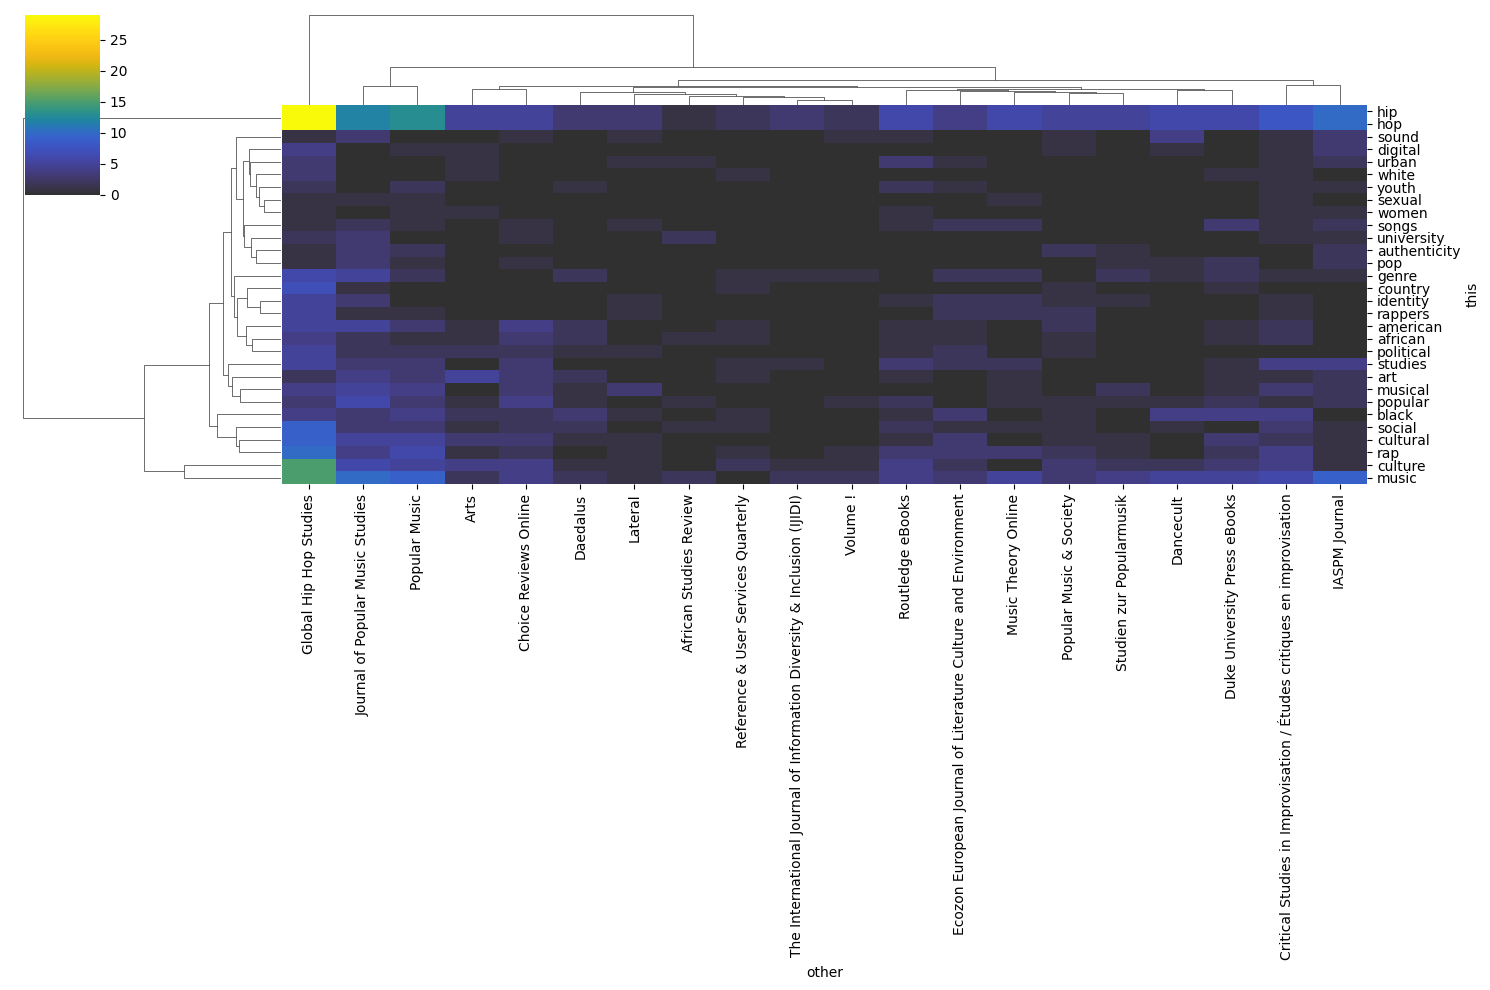

In [ ]:
axes = sns.clustermap(paratextual_cooccurrence_counts, method='average', cmap=colorcet.linear_kbgoy_20_95_c57, figsize=(15, 10))

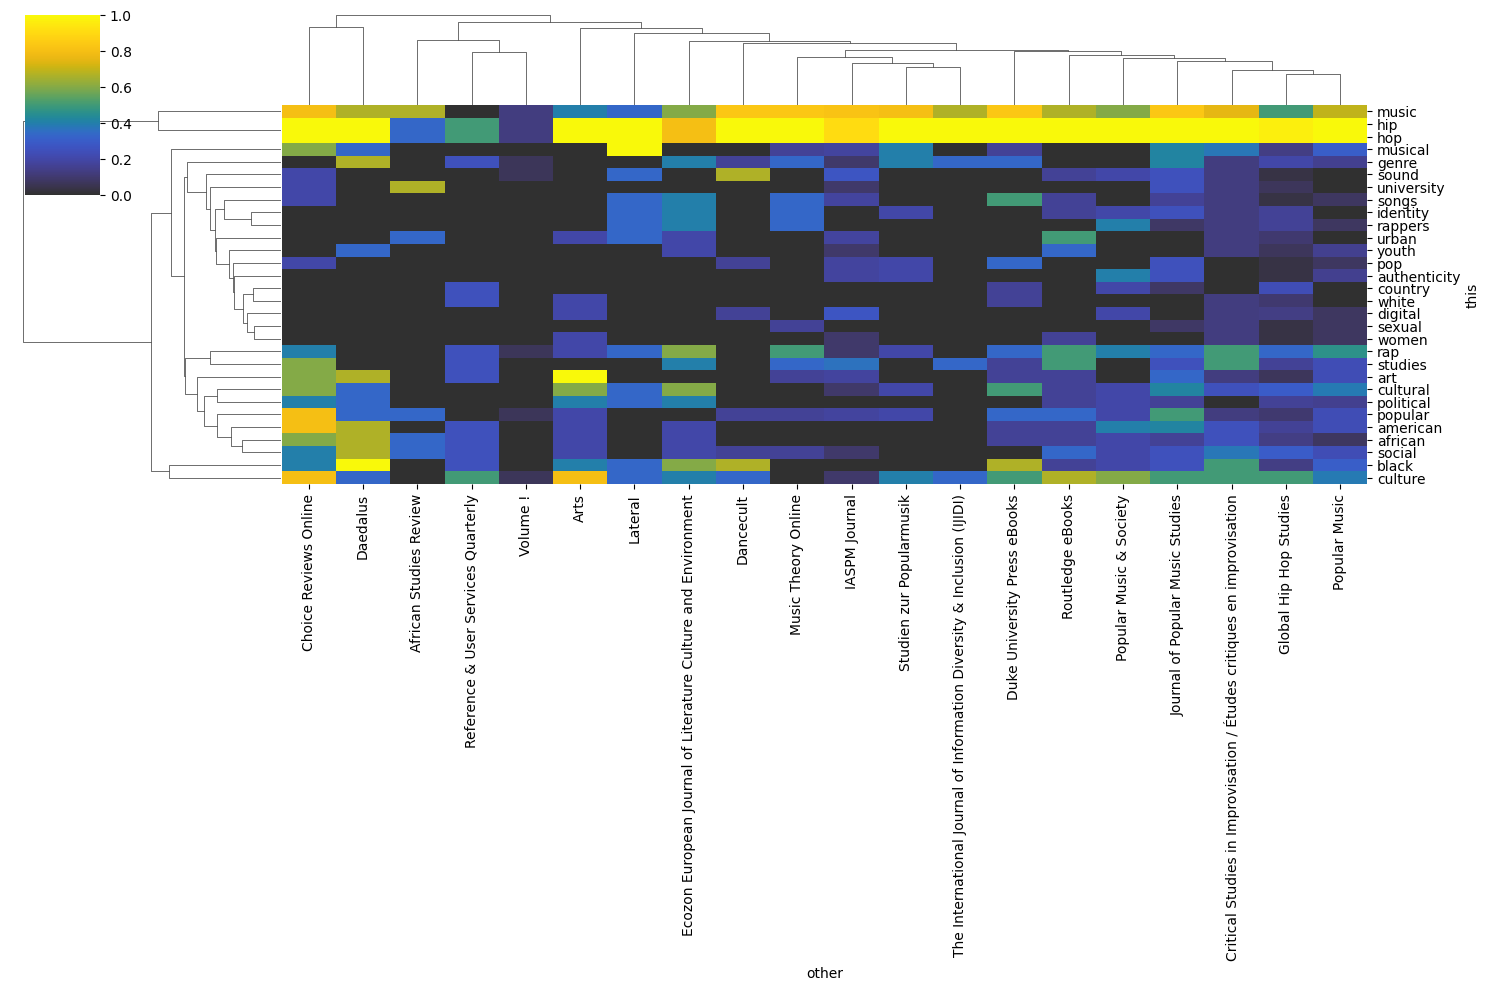

In [ ]:
selection_count = paratextual_counts.loc[paratextual_cooccurrence_counts.columns]
normalized_paratextual_cooccurrence_counts = paratextual_cooccurrence_counts.div(selection_count, axis=1)

axes = sns.clustermap(normalized_paratextual_cooccurrence_counts, method='average', cmap=colorcet.linear_kbgoy_20_95_c57, figsize=(15, 10))

In [ ]:
from pathlib import Path
import re

import colorcet
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
from spacy import displacy

In [ ]:
INPUT_SOURCE_DATA = 'works-2025-06-26T20-54-21.csv'
INPUT_SPACY_DOCUMENTS_EN_DEP_NEWS_TRF = '/content/pickles/docs @sel:all @spacy:en_dep_news_trf @len:588.pickle'
INPUT_SPACY_DOCUMENTS_EN_CORE_NEWS_LG='/content/pickles/docs @sel:all @spacy:en_core_web_md @len:588.pickle'

OUTPUT_SEL_VIVANT_NOUN_NOT_PERIOD='pickles/sel @on:vivant_noun_not_period.pickle'

In [ ]:
df_original = pd.read_csv(INPUT_SOURCE_DATA, low_memory=False)

len(df_original)

5694

In [ ]:
all_docs_trf = pd.read_pickle(INPUT_SPACY_DOCUMENTS_EN_DEP_NEWS_TRF)

In [ ]:
df_documents = df_original.loc[all_docs_trf.index]

len(df_documents)

588

In [ ]:
# Uncomment the following line to work with only the first 100 documents
#df_documents = df_documents.iloc[:100]

# Uncomment the following line to work with a sample of 100 documents
#df_documents = df_documents.sample(100)

len(df_documents)

588

In [ ]:
df_documents = df_documents.copy()

In [ ]:
d = all_docs_trf.iloc[1]
t = d[2]
print(next(d.sents))
pd.Series({'text': t.text, 'lemma': t.lemma_, 'pos': t.pos_, 'children': [x for x in t.children], 'head': t.head, 'dep': t.dep_})

Yancy, Hadley, Give 'em  One Mic: The Therapeutic Agency of Rap and Hip-Hop.


text          Hadley
lemma         Hadley
pos            PROPN
children          []
head            Give
dep         npadvmod
dtype: object

In [ ]:
for sent in d.sents:
    displacy.render(sent)

In [ ]:
def is_vivant_substantif(token):
    return token.lemma_ == 'rap' and token.pos_ == 'NOUN'

In [ ]:
sel_vivant_noun = all_docs_trf.map(
    lambda doc: any(
        token for token in doc
        if is_vivant_substantif(token)
    )
)

In [ ]:
all_docs_trf[~sel_vivant_noun].iloc[1]

It has been more than thirty-five years since the first commercial recordings of hip-hop music were made. This Companion, written by renowned scholars and industry professionals reflects the passion and scholarly activity occurring in the new generation of hip-hop studies. It covers a diverse range of case studies from Nerdcore hip-hop to instrumental hip-hop to the role of rappers in the Obama campaign and from countries including Senegal, Japan, Germany, Cuba, and the UK. Chapters provide an overview of the &amp;apos;four elements&amp;apos; of hip-hop - MCing, DJing, break dancing (or breakin&amp;apos;), and graffiti - in addition to key topics such as religion, theatre, film, gender, and politics. Intended for students, scholars, and the most serious of &amp;apos;hip-hop heads&amp;apos;, this collection incorporates methods in studying hip-hop flow, as well as the music analysis of hip-hop and methods from linguistics, political science, gender and film studies to provide exciting n

In [ ]:
docs = all_docs_trf[sel_vivant_noun].copy()

In [ ]:
def get_head_for_token(doc, token_lemma="rap", token_pos="NOUN", head_pos="VERB"):
    uses_of_token = [
        token
        for token in doc
        if token.lemma_ == token_lemma and (token_pos is None or token.pos_ == token_pos)
    ]
    tokens_deps_heads = [
        {
            'token': token,
            'dep': token.dep_,
            'head_lemma': token.head.lemma_,
            'context': token.doc[max(0, token.i-4):min(len(token.doc), token.i+4)].text,
        }
        for token in uses_of_token
        if (head_pos is None or token.head.pos_ == head_pos)
    ]
    return tokens_deps_heads

In [ ]:
df_token_dep_head = docs.map(lambda doc: get_head_for_token(doc, token_lemma='rap', token_pos='NOUN', head_pos='VERB')).explode().dropna()
df_token_dep_head = df_token_dep_head.apply(pd.Series) # Convert the `dict`s into Series, so `.apply()` will output a DataFrame with the keys as columns

df_token_dep_head

token        dep    head_lemma  \
2      rap      nsubj       express   
53     Rap       dobj           use   
315    rap       oprd         brand   
651    rap  nsubjpass       include   
651   raps       dobj         share   
685    Rap      nsubj        emerge   
685    rap       dobj        employ   
685    rap      nsubj         serve   
851    rap       oprd         brand   
1094   rap      nsubj       express   
1189   rap      nsubj    experience   
1844   rap      nsubj         cross   
2065   rap      nsubj          deal   
2393   rap  nsubjpass           see   
2625   rap       pobj       include   
2625   rap      nsubj       surpass   
2625   rap      nsubj          have   
2672   rap      nsubj         serve   
3713   rap       dobj        depict   
4211   rap      nsubj         serve   
4308   rap  nsubjpass        intend   
4483   rap      nsubj           use   
4483   rap  nsubjpass        regard   
4483   rap       dobj          read   
4564   Rap      nsubj         force   
4564   rap       dobj          sell   
4564   rap       dobj          sell   
4712   Rap      nsubj        depend   
4738   rap      nsubj          gain   
4738   rap      nsubj          turn   
4738   rap  nsubjpass          mark   
4738   rap      nsubj        become   
4942   rap      nsubj        assert   
4942   rap     dative          give   
4972   rap  nsubjpass      dominate   
4972   rap      nsubj           fit   
5018   rap      nsubj        emerge   
5018   rap       dobj        engage   
5018   rap       oprd          call   
5018   rap      nsubj     represent   
5018   Rap  nsubjpass      perceive   
5084   Rap      nsubj        become   
5084   rap      nsubj          make   
5111   rap       dobj          link   
5130   rap       dobj          call   
5130   rap      nsubj      continue   
5130   rap      nsubj       provide   
5135   rap      nsubj   incorporate   
5135   rap  nsubjpass  characterize   
5324   rap  nsubjpass     translate   
5573   rap       dobj       produce   
5573   rap       dobj          sell   

                                                context  
2     may be disconcerting, rap often expresses bril...  
53    Creating Original Songs Using Rap with Women with  
315            commonly branded "jazz rap." Connections  
651   Bangladeshi Muslim youth whose rap is not incl...  
651                 . Samuel shared his raps at a later  
685                  coping with hegemony. Rap and hip-  
685                 culture, have employed rap and hip-  
685                  The study argues that rap and hip-  
851            commonly branded "jazz rap." Connections  
1094  may be disconcerting, rap often expresses bril...  
1189  especially since 2000 when rap in Germany expe...  
1844                    . The 2000s saw rap and hip hop  
2065         . Greve scrutinizes how rap has dealt with  
2393               , and that jihadi rap should be seen  
2625                 -Hop (including rap) had overtaken  
2625  Nielsen Music reported that rap had surpassed ...  
2625         at best relationship that rap has had with  
2672                      . In short, rap serves as the  
3713            -hop culture depict rap as a vernacular  
4211                    . It shows how rap can serve as  
4308         France during the 1990 rap was intended to  
4483      hip hop, Irish rap uses oppositional politics  
4483         to argue that Irish rap should be regarded  
4483            this article reads Irish rap as poetry.  
4564                        . . . . Rap can force white  
4564   musical industry that sold rap in record numbers  
4564            industry not only sold rap in this form  
4712                                   Rap, the musical  
4738            -hop culture, rap is gaining popularity  
4738       is absolutely clear that rap has turned from  
4738                    . High-quality rap is marked by  
4738                get it. Russian rap has become part  
4942     hop scenes. Se

In [ ]:
for token in df_token_dep_head['token'].iloc[[0,1,2,3,4,-5,-4,-3,-2,-1]]:
    displacy.render(token.sent)

In [ ]:
def is_vivant_as_period(token_vivant):
    if token_vivant.norm_ != "rap" or token_vivant.dep_ != "obl:mod":
        return False
    has_de = False
    has_son = False
    has_du = False
    has_nmod = False
    for child in token_vivant.children:
        if child.norm_ == "de" and child.dep_ == "case":
            has_de = True
        elif child.norm_ in {"son", "leur"} and child.dep_ == "det":
            has_son = True
        elif child.norm_ == "du" and child.dep_ == "case":
            has_du = True
        elif child.pos_ == "NOUN" and child.dep_ == "nmod":
            for nmod_child in child.children:
                if nmod_child.norm_ in {"du", "de"} and nmod_child.dep_ == "case":
                    has_nmod = True
    is_de_son_vivant = has_de and has_son
    is_du_vivant_de_nmod = has_du and has_nmod
    return is_de_son_vivant or is_du_vivant_de_nmod

In [ ]:
df_token_dep_head = df_token_dep_head.loc[lambda df: ~df['token'].map(is_vivant_as_period)]

df_token_dep_head

token        dep    head_lemma  \
2      rap      nsubj       express   
53     Rap       dobj           use   
315    rap       oprd         brand   
651    rap  nsubjpass       include   
651   raps       dobj         share   
685    Rap      nsubj        emerge   
685    rap       dobj        employ   
685    rap      nsubj         serve   
851    rap       oprd         brand   
1094   rap      nsubj       express   
1189   rap      nsubj    experience   
1844   rap      nsubj         cross   
2065   rap      nsubj          deal   
2393   rap  nsubjpass           see   
2625   rap       pobj       include   
2625   rap      nsubj       surpass   
2625   rap      nsubj          have   
2672   rap      nsubj         serve   
3713   rap       dobj        depict   
4211   rap      nsubj         serve   
4308   rap  nsubjpass        intend   
4483   rap      nsubj           use   
4483   rap  nsubjpass        regard   
4483   rap       dobj          read   
4564   Rap      nsubj         force   
4564   rap       dobj          sell   
4564   rap       dobj          sell   
4712   Rap      nsubj        depend   
4738   rap      nsubj          gain   
4738   rap      nsubj          turn   
4738   rap  nsubjpass          mark   
4738   rap      nsubj        become   
4942   rap      nsubj        assert   
4942   rap     dative          give   
4972   rap  nsubjpass      dominate   
4972   rap      nsubj           fit   
5018   rap      nsubj        emerge   
5018   rap       dobj        engage   
5018   rap       oprd          call   
5018   rap      nsubj     represent   
5018   Rap  nsubjpass      perceive   
5084   Rap      nsubj        become   
5084   rap      nsubj          make   
5111   rap       dobj          link   
5130   rap       dobj          call   
5130   rap      nsubj      continue   
5130   rap      nsubj       provide   
5135   rap      nsubj   incorporate   
5135   rap  nsubjpass  characterize   
5324   rap  nsubjpass     translate   
5573   rap       dobj       produce   
5573   rap       dobj          sell   

                                                context  
2     may be disconcerting, rap often expresses bril...  
53    Creating Original Songs Using Rap with Women with  
315            commonly branded "jazz rap." Connections  
651   Bangladeshi Muslim youth whose rap is not incl...  
651                 . Samuel shared his raps at a later  
685                  coping with hegemony. Rap and hip-  
685                 culture, have employed rap and hip-  
685                  The study argues that rap and hip-  
851            commonly branded "jazz rap." Connections  
1094  may be disconcerting, rap often expresses bril...  
1189  especially since 2000 when rap in Germany expe...  
1844                    . The 2000s saw rap and hip hop  
2065         . Greve scrutinizes how rap has dealt with  
2393               , and that jihadi rap should be seen  
2625                 -Hop (including rap) had overtaken  
2625  Nielsen Music reported that rap had surpassed ...  
2625         at best relationship that rap has had with  
2672                      . In short, rap serves as the  
3713            -hop culture depict rap as a vernacular  
4211                    . It shows how rap can serve as  
4308         France during the 1990 rap was intended to  
4483      hip hop, Irish rap uses oppositional politics  
4483         to argue that Irish rap should be regarded  
4483            this article reads Irish rap as poetry.  
4564                        . . . . Rap can force white  
4564   musical industry that sold rap in record numbers  
4564            industry not only sold rap in this form  
4712                                   Rap, the musical  
4738            -hop culture, rap is gaining popularity  
4738       is absolutely clear that rap has turned from  
4738                    . High-quality rap is marked by  
4738                get it. Russian rap has become part  
4942     hop scenes. Se

In [ ]:
vivant_verb_dep_counts = df_token_dep_head[['dep', 'head_lemma']].value_counts().unstack('dep').fillna(0)

vivant_verb_dep_counts

dep           dative  dobj  nsubj  nsubjpass  oprd  pobj
head_lemma                                              
assert           0.0   0.0    1.0        0.0   0.0   0.0
become           0.0   0.0    2.0        0.0   0.0   0.0
brand            0.0   0.0    0.0        0.0   2.0   0.0
call             0.0   1.0    0.0        0.0   1.0   0.0
characterize     0.0   0.0    0.0        1.0   0.0   0.0
continue         0.0   0.0    1.0        0.0   0.0   0.0
cross            0.0   0.0    1.0        0.0   0.0   0.0
deal             0.0   0.0    1.0        0.0   0.0   0.0
depend           0.0   0.0    1.0        0.0   0.0   0.0
depict           0.0   1.0    0.0        0.0   0.0   0.0
dominate         0.0   0.0    0.0        1.0   0.0   0.0
emerge           0.0   0.0    2.0        0.0   0.0   0.0
employ           0.0   1.0    0.0        0.0   0.0   0.0
engage           0.0   1.0    0.0        0.0   0.0   0.0
experience       0.0   0.0    1.0        0.0   0.0   0.0
express          0.0   0.0    2.0        0.0   0.0   0.0
fit              0.0   0.0    1.0        0.0   0.0   0.0
force            0.0   0.0    1.0        0.0   0.0   0.0
gain             0.0   0.0    1.0        0.0   0.0   0.0
give             1.0   0.0    0.0        0.0   0.0   0.0
have             0.0   0.0    1.0        0.0   0.0   0.0
include          0.0   0.0    0.0        1.0   0.0   1.0
incorporate      0.0   0.0    1.0        0.0   0.0   0.0
intend           0.0   0.0    0.0        1.0   0.0   0.0
link             0.0   1.0    0.0        0.0   0.0   0.0
make             0.0   0.0    1.0        0.0   0.0   0.0
mark             0.0   0.0    0.0        1.0   0.0   0.0
perceive         0.0   0.0    0.0        1.0   0.0   0.0
produce          0.0   1.0    0.0        0.0   0.0   0.0
provide          0.0   0.0    1.0        0.0   0.0   0.0
read             0.0   1.0    0.0        0.0   0.0   0.0
regard           0.0   0.0    0.0        1.0   0.0   0.0
represent        0.0   0.0    1.0        0.0   0.0   0.0
see              0.0   0.0    0.0        1.0   0.0   0.0
sell             0.0   3.0    0.0        0.0   0.0   0.0
serve            0.0   0.0    3.0        0.0   0.0   0.0
share            0.0   1.0    0.0        0.0   0.0   0.0
surpass          0.0   0.0    1.0        0.0   0.0   0.0
translate        0.0   0.0    0.0        1.0   0.0   0.0
turn             0.0   0.0    1.0        0.0   0.0   0.0
use              0.0   1.0    1.0        0.0   0.0   0.0

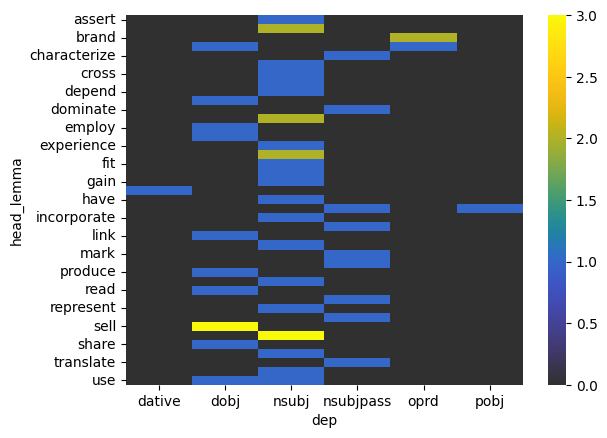

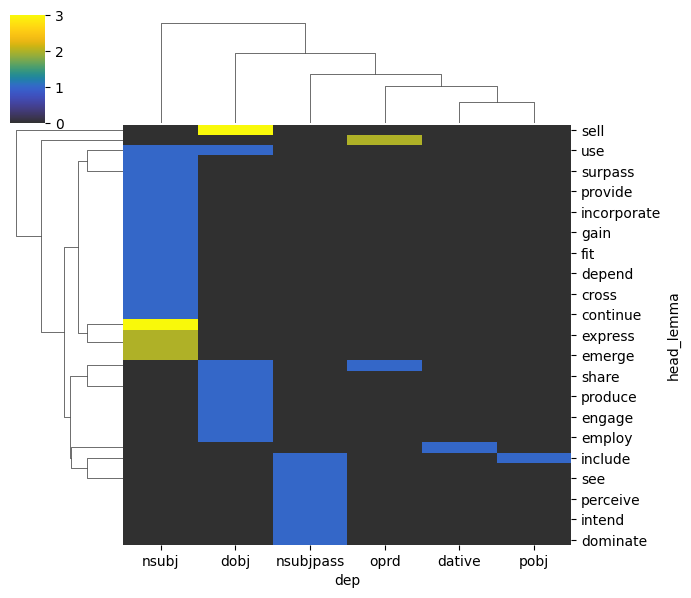

In [ ]:
sns.heatmap(
    vivant_verb_dep_counts,
    cmap=colorcet.linear_kbgoy_20_95_c57,
)
sns.clustermap(
    vivant_verb_dep_counts,
    cmap=colorcet.linear_kbgoy_20_95_c57,
    figsize=(7,6),
)

<Axes: xlabel='dep'>

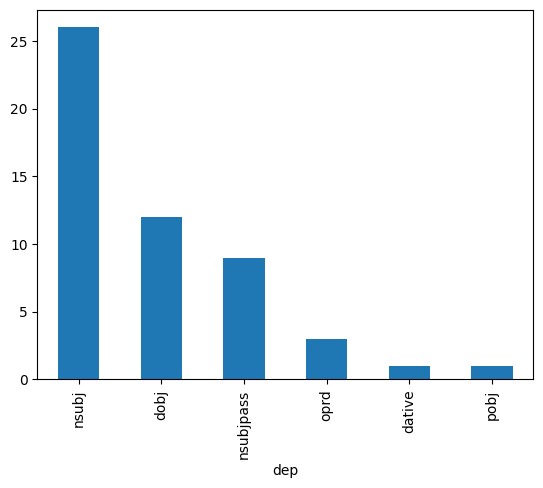

In [ ]:
vivant_verb_dep_counts.sum().sort_values(ascending=False).plot.bar()

In [ ]:
# Define a dictionary of combined deps
clear_dep_deps = {
    "agent": ["nsubj"],
    "object": ["dobj", "nsubjpass"],
    "related": ["pobj"]  # possession/relation
}

# Define the reverse dictionary, to be used later
dep_clear_dep = {dep: clear_dep for clear_dep, deps in clear_dep_deps.items() for dep in deps}

# Create a new dataframe with the sums of values for deps we combine
vivant_verb_clear_dep_counts = pd.DataFrame(
    {
        clear_dep: sum(vivant_verb_dep_counts[dep] for dep in deps if dep in vivant_verb_dep_counts.columns)
        for clear_dep, deps in clear_dep_deps.items()
    },
    index=vivant_verb_dep_counts.index
)

# Explications des rôles
dep_explanations = {
    "agent": "Ce que le rap fait",
    "object": "Ce que l'on fait du rap",
    "related": "Ce que l'on fait en lien avec le rap",
}

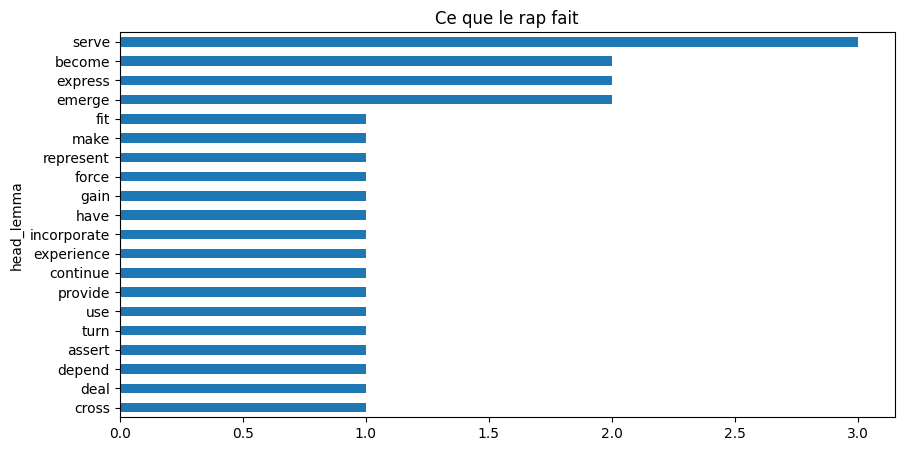

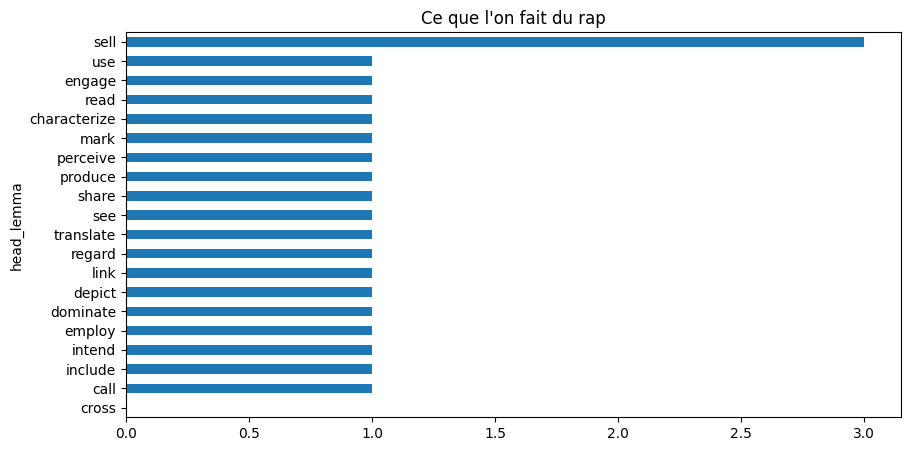

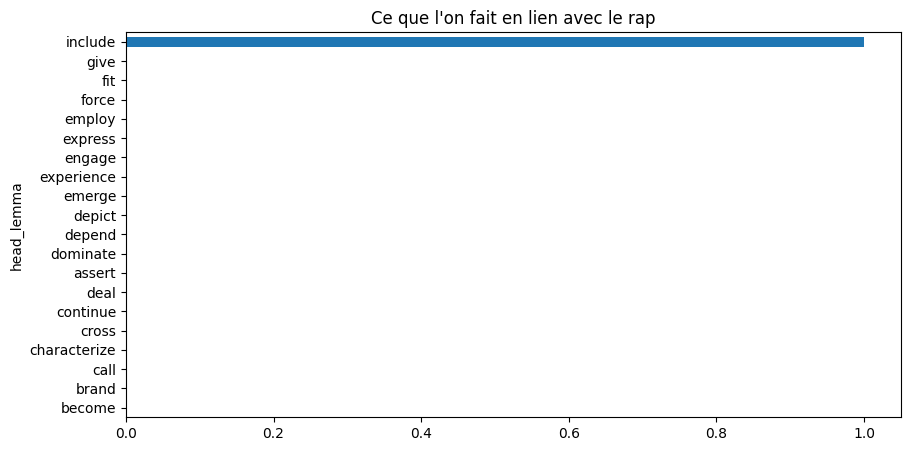

In [ ]:
for col_name, col_sr in vivant_verb_clear_dep_counts.items():
    col_sr.sort_values(ascending=False).iloc[:20].sort_values().plot.barh(title=dep_explanations[col_name], figsize=(10,5))
    plt.show()

In [ ]:
sel_vivant_noun_not_period = all_docs_trf.map(
    lambda doc: any(
        token for token in doc
        if is_vivant_substantif(token) and not is_vivant_as_period(token)
    )
)

In [ ]:
sel_vivant_noun_not_period.to_pickle(OUTPUT_SEL_VIVANT_NOUN_NOT_PERIOD)

In [ ]:
all_docs_trf[~sel_vivant_noun_not_period].iloc[1]

It has been more than thirty-five years since the first commercial recordings of hip-hop music were made. This Companion, written by renowned scholars and industry professionals reflects the passion and scholarly activity occurring in the new generation of hip-hop studies. It covers a diverse range of case studies from Nerdcore hip-hop to instrumental hip-hop to the role of rappers in the Obama campaign and from countries including Senegal, Japan, Germany, Cuba, and the UK. Chapters provide an overview of the &amp;apos;four elements&amp;apos; of hip-hop - MCing, DJing, break dancing (or breakin&amp;apos;), and graffiti - in addition to key topics such as religion, theatre, film, gender, and politics. Intended for students, scholars, and the most serious of &amp;apos;hip-hop heads&amp;apos;, this collection incorporates methods in studying hip-hop flow, as well as the music analysis of hip-hop and methods from linguistics, political science, gender and film studies to provide exciting n

In [ ]:
docs = all_docs_trf[sel_vivant_noun_not_period].copy()

In [ ]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 1.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
nlp_lg = spacy.load('en_core_web_md')  # Changez ici !

In [ ]:
example_entities = nlp_lg("Je m'appelle Polonius, je vis à Marne la Vallée et je travaille à l'Université Gustave Eiffel. J'aime beaucoup le théatre dont les pièces du Barde.").ents

example_entities

(Je m'appelle Polonius, je vis à Marne)

In [ ]:
all_docs_lg = pd.read_pickle(INPUT_SPACY_DOCUMENTS_EN_CORE_NEWS_LG)

len(all_docs_lg)

588

In [ ]:
docs_lg = all_docs_lg.loc[sel_vivant_noun_not_period]

len(docs_lg)

144

In [ ]:
sr_ents = docs_lg.map(lambda doc: [ent for ent in doc.ents])        # pour chaque document: la liste des entités trouvées
sr_ent_texts = sr_ents.map(lambda ents: [ent.text for ent in ents]) # pour chaque document: la liste du texte correspondant à chacune des entités trouvées
sr_ent_texts.apply(pd.Series)                                       # pour obtenir un DataFrame dont les lignes sont la série des éléments des listes

0                                1   \
2                       the United States                      Imani Perry   
53                                  Yancy                           Hadley   
183   Justin A. Williams Part I. Elements                                1   
266                      African-American     the United States of America   
274                             the 1970s                    the early 90s   
...                                   ...                              ...   
5413                             Nigerian                         Nigerian   
5475                                 1970                             1980   
5522                            São Paulo                     Casa Zezinho   
5573                     Snoop Doggy Dogg  Flow SPENCER HAWKINS Reputation   
5591                         Tayin Falola                    Tyler Fleming   

                                        2                              3   \
2                                    Perry                 Perry advances   
53                                     One  The Therapeutic Agency of Rap   
183                   Alice Price-Styles 2             Imani K. Johnson 3   
266                          the Civil War                 Kendrick Lamar   
274   the early 21&lt;sup&gt;st&lt;/sup&gt                        century   
...                                    ...                            ...   
5413                         21 st century                       Facebook   
5475                                   one              Africaa Bambaataa   
5522                                   NGO                        Redondo   
5573                                 Greek                       American   
5591                               African                        African   

                          4                  5                          6   \
2                      first           American                      Perry   
53                      Hara               Ally  Contextualizing Rap Music   
183            Ivor Miller 4              fifth              Travis Gosa 6   
266         Pimp a Butterfly  the United States          African Americans   
274                   Eminem                NaN                        NaN   
...                      ...                ...                        ...   
5413                Nigerian                six                   Nigerian   
5475                     NaN                NaN                        NaN   
5522  between the ages of 13                 15                        NaN   
5573                  Greeks                two            the early 1990s   
5591                 African                 10                    African   

                        7                      8                 9   ...   48  \
2                 Ice Cube                OutKast      Tupac Shakur  ...  NaN   
53           Psychotherapy             Lightstone  Music Therapists  ...  NaN   
183   Christina Zanfagna 7  Nicole Hodges Persley                 8  ...  NaN   
266                  Lamar       African-American      Paul Tillich  ...  NaN   
274                    NaN                    NaN               NaN  ...  NaN   
...                    ...                    ...               ...  ...  ...   
5413               Olamide                   Teni          Lil Kesh  ...  NaN   
5475                   NaN                    NaN               NaN  ...  NaN   
5522                   NaN                    NaN               NaN  ...  NaN   
5573                 first       Classical Greece              24.1  ...  NaN   
5591                  four                African           African  ...  NaN   

       49   50   51   52   53   54   55   56   57  
2     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
53    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
183   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
266   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
274   N

In [ ]:
(
    sr_ent_texts
    .apply(set)                                      # préservons uniquement un seul exemplaire, c'est à dire, si l'entité est présente ou pas
    .explode()                                       # pour obtenir la série des éléments des ensembles
    .value_counts()
)

docs
American             23
the United States    20
three                19
two                  18
first                17
                     ..
Tanzanian             1
Tanzanians            1
Slavoj Žižek          1
Snoop Doggy Dogg      1
Barbara Cassin        1
Name: count, Length: 942, dtype: int64

In [ ]:
def get_head_for_entity(ent, poss=None, deps=None):
    """
    If the head of the entity has its part of speech in `poss`, return:
    - the text of the entity
    - the label which characterizes it as a person (PER), place (LOC) etc.
    - the kind of dependecy (`dep`) it has on its head
    - the lemma of the head
    - the POS of the head
    - the words surrounding the entity
    Optionally require that the dependency between root and verb be found in a set of `deps`.
    E.g.: `poss={'VERB'}`, `deps={"nsubj", "obl:agent"}`
    """
    root = ent.root
    head = root.head
    if (poss is None or head.pos_ in poss) and (deps is None or root.dep_ in deps):
        ent_head_pos_context = {
            "entity_text": ent.text,
            "label": ent.label_,
            "dep": root.dep_,
            "clear_dep": dep_clear_dep.get(root.dep_, root.dep_),
            "head_lemma": head.lemma_,
            "head_pos": head.pos_,
            'context': root.doc[max(0, root.i-4): min(len(root.doc), root.i+4)].text,
        }
    else:
        ent_head_pos_context = None
    return ent_head_pos_context

In [ ]:
ents_info = sr_ents.explode().dropna().map(get_head_for_entity).apply(pd.Series)

ents_info

entity_text    label    dep clear_dep    head_lemma head_pos  \
2     the United States      GPE   pobj   related            in      ADP   
2           Imani Perry   PERSON  nsubj     agent       provide     VERB   
2                 Perry   PERSON  nsubj     agent      consider     VERB   
2        Perry advances   PERSON   ROOT      ROOT       advance     VERB   
2                 first  ORDINAL   amod      amod         music     NOUN   
...                 ...      ...    ...       ...           ...      ...   
5591               Faso      GPE   pobj   related            in      ADP   
5591              Obeng      ORG  nsubj     agent          show     VERB   
5591          Chikowero     DATE  appos     appos         Obeng    PROPN   
5591          Bruhwiler   PERSON   poss      poss  contribution     NOUN   
5591            pp.9-14      ORG  appos     appos          past     NOUN   

                                                context  
2                   force in the United States, hip hop  
2     kind of interpretation Imani Perry provides here:  
2                    and a fan, Perry considers the art  
2      musical form, Perry advances a powerful argument  
2              that hip hop is first and foremost black  
...                                                 ...  
5591  how takiboronse in Burkina Faso has been instr...  
5591                dominance. Also, Obeng's, Chikowero  
5591                        , Obeng's, Chikowero's, and  
5591  Chikowero's, and Bruhwiler's respective contri...  
5591                              in the past (pp.9-14)  

[1687 rows x 7 columns]

In [ ]:
def get_most_cited(sr):
    most_cited = pd.DataFrame(
    {
        "frequency": sr.value_counts(),
        "presence": sr.groupby(level=0).agg(set).explode().value_counts(),
    }
).sort_values(["presence", "frequency"], ascending=False)
    return most_cited

In [ ]:
loc_ents = ents_info.loc[lambda df: df['label'].eq('LOC'), 'entity_text']
get_most_cited(loc_ents)

frequency  presence
entity_text                          
Africa                    2         2
Europe                    2         2
the Global South          2         2
South                     4         1
West Coast                2         1
Arctic                    1         1
Asia                      1         1
Bay Area                  1         1
Caribbean                 1         1
Classical Greece          1         1
Dakar                     1         1
Earth                     1         1
Freestyle                 1         1
Jianghu                   1         1
Latin America             1         1
Louth                     1         1
Mars                      1         1
North America             1         1
White America             1         1
the Bay Area              1         1
the Golden Age            1         1
the South Bronx           1         1

In [ ]:
per_ents = ents_info.loc[lambda df: df['label'].eq('PER'), 'entity_text']
get_most_cited(per_ents)

Empty DataFrame
Columns: [frequency, presence]
Index: []

In [ ]:
ents_info["head_clear_dep"] = ents_info.agg(lambda row: f'{row["head_lemma"]} ({row["clear_dep"]})', axis=1)

In [ ]:
per_ents_verb_head_deps = ents_info.loc[lambda df: df['label'].eq('PER'), ['entity_text', 'head_clear_dep']]
get_most_cited(per_ents_verb_head_deps["head_clear_dep"]).iloc[:20]

Empty DataFrame
Columns: [frequency, presence]
Index: []

In [ ]:
per_ents_verb_head_deps = ents_info.loc[lambda df: df['label'].eq('PER'), ['entity_text', 'head_clear_dep']]
get_most_cited(per_ents_verb_head_deps["head_clear_dep"]).iloc[:20]

Empty DataFrame
Columns: [frequency, presence]
Index: []

In [ ]:
ents_x_head_counts = (
    ents_info
    .loc[lambda df:  df['label'].eq('PER'), ['entity_text', 'head_clear_dep']]
    .value_counts()
    .unstack('entity_text')
    .fillna(0)
    .astype(int)
)

ents_x_head_counts

Empty DataFrame
Columns: []
Index: []

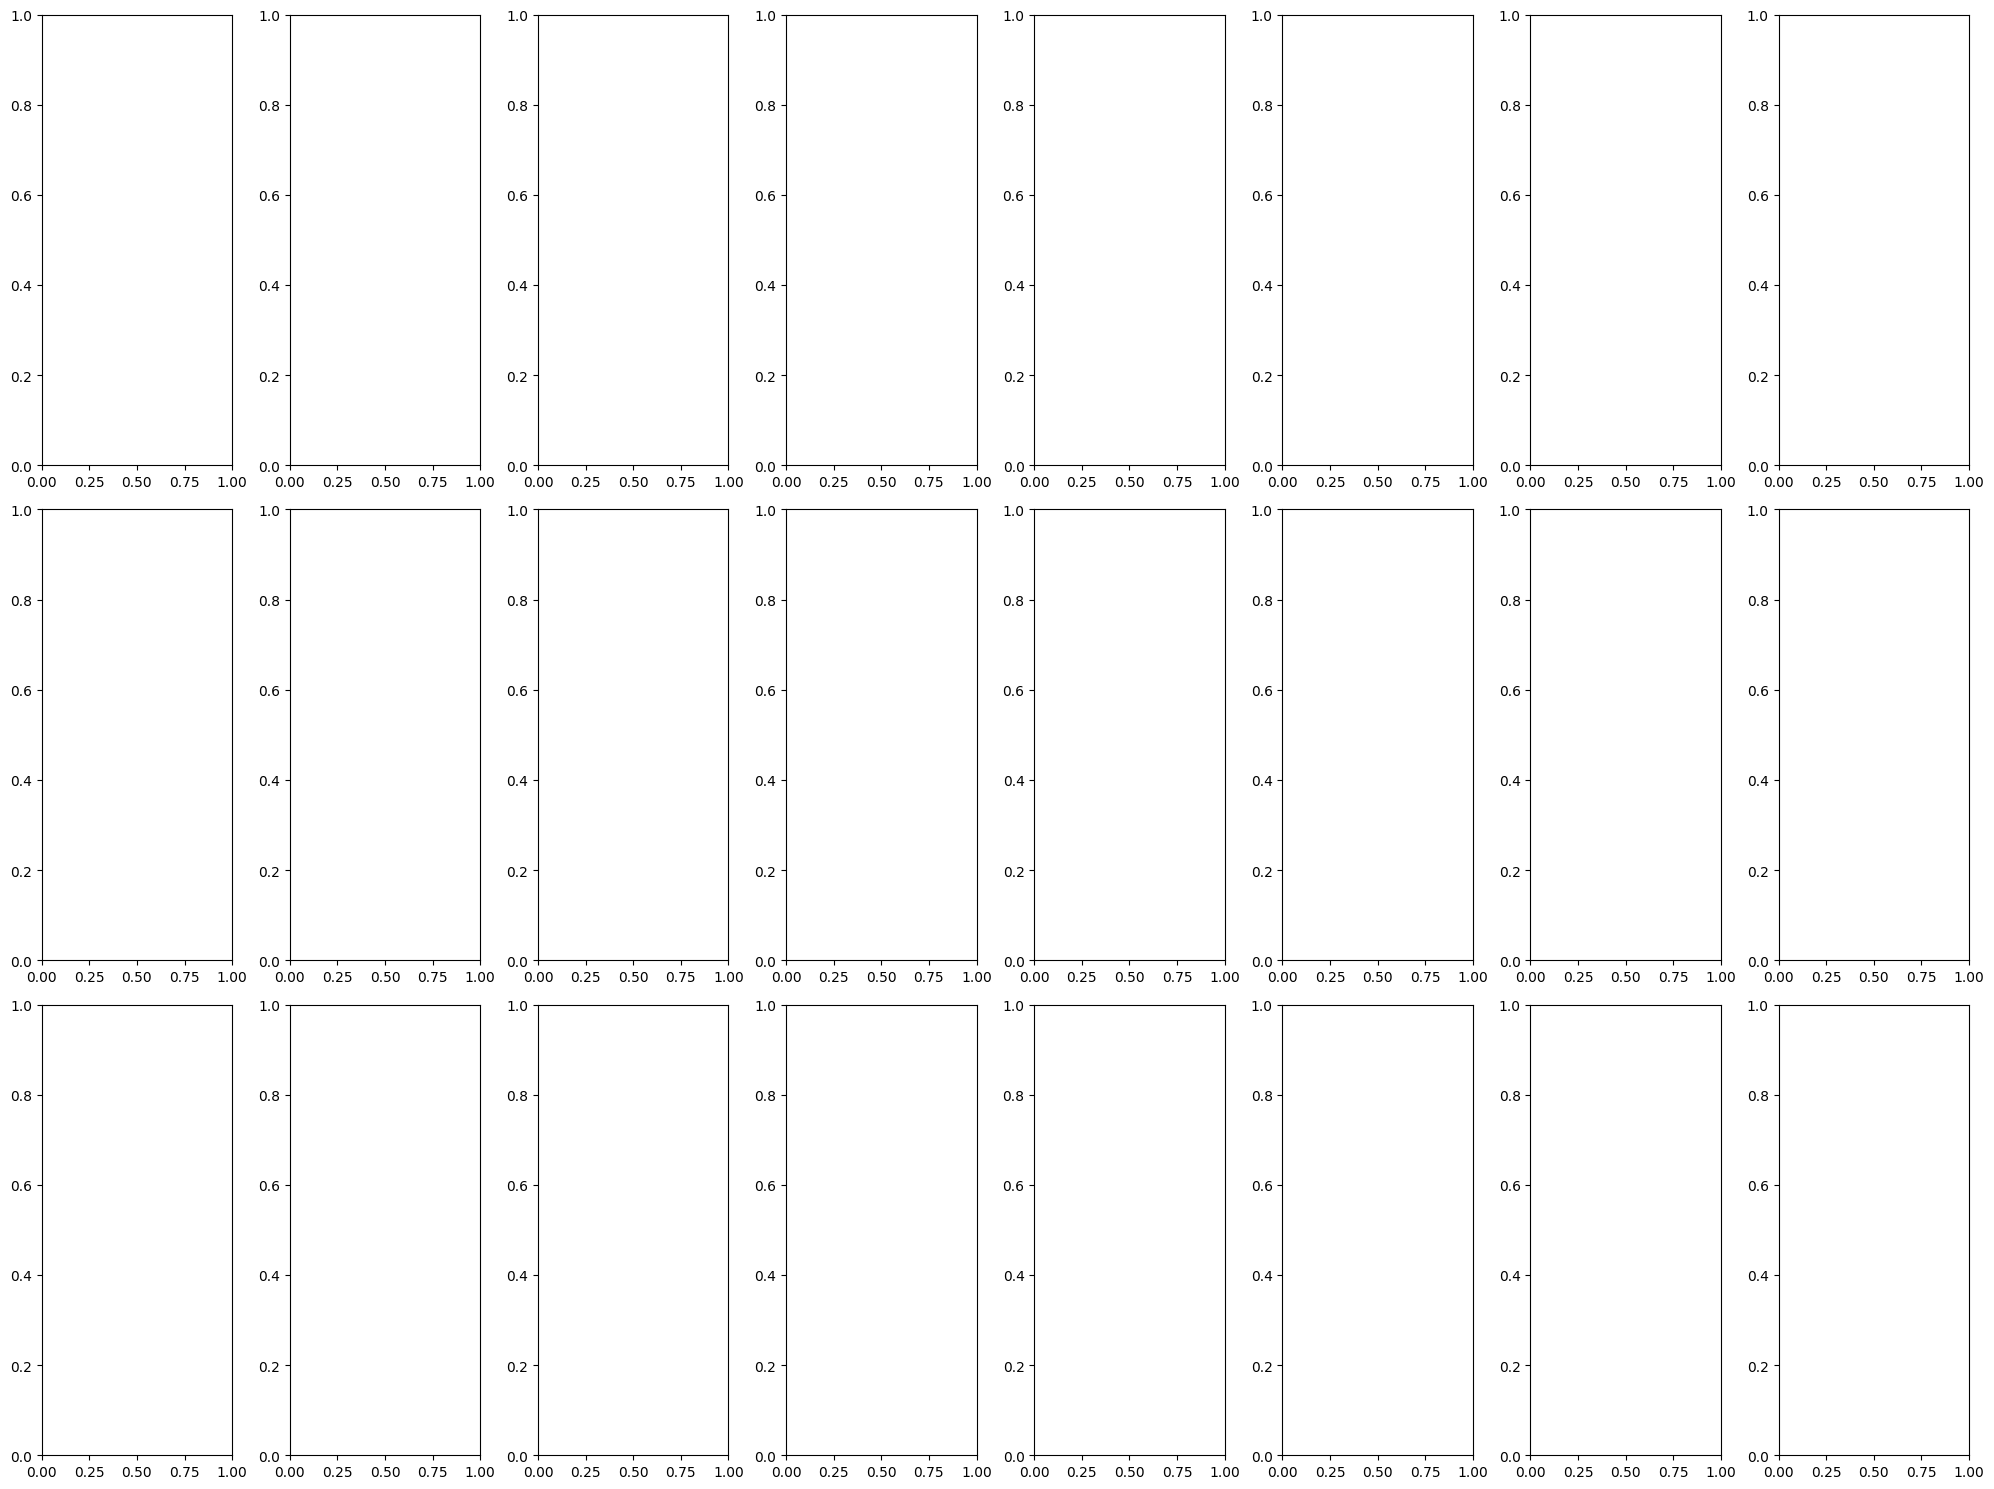

In [ ]:
total_rows = 3
total_cols = 8
num_heads = 17
sorted_pers = top_pers = ents_x_head_counts.sum().sort_values(ascending=False).index
figure, axes = plt.subplots(total_rows, total_cols, figsize=(2.5*total_cols, 15))
for per, ax in zip(sorted_pers, (ax for axs in axes for ax in axs)):
    per_heads = ents_x_head_counts[per][lambda sr: sr.gt(0)].sort_values(ascending=False).index[:num_heads]
    ax = sns.heatmap(
        ents_x_head_counts.loc[per_heads, [per]],
        cmap=colorcet.linear_kbgoy_20_95_c57,
        vmin=0,
        vmax=ents_x_head_counts.max().max(),
        cbar=False,
        annot=True,
        ax=ax,
    )
    ax.set_xlabel(" ")
figure.tight_layout()

In [38]:
def get_per_head_info(ents_info, per, head_clear_dep):
    per_head_info = ents_info.loc[
        lambda df:
            df['entity_text'].eq(per)
            & df['head_clear_dep'].eq(head_clear_dep)
    ]
    return per_head_info

In [39]:
def get_per_head_info(ents_info, per, head_clear_dep):
    per_head_info = ents_info.loc[
        lambda df:
            df['entity_text'].eq(per)
            & df['head_clear_dep'].eq(head_clear_dep)
    ]
    return per_head_info

In [40]:
import os
IN_COLAB = os.getenv("COLAB_RELEASE_TAG")
if IN_COLAB:
    %pip install -q condacolab
    import condacolab
    condacolab.install()
else:
    print("You may need to install graph-tool manually!")

✨🍰✨ Everything looks OK!


In [41]:
if IN_COLAB:
    !mamba install -q graph-tool

In [42]:
import graph_tool.all as gt

In [43]:
g = gt.collection.data["celegansneural"]
state = gt.minimize_nested_blockmodel_dl(g)

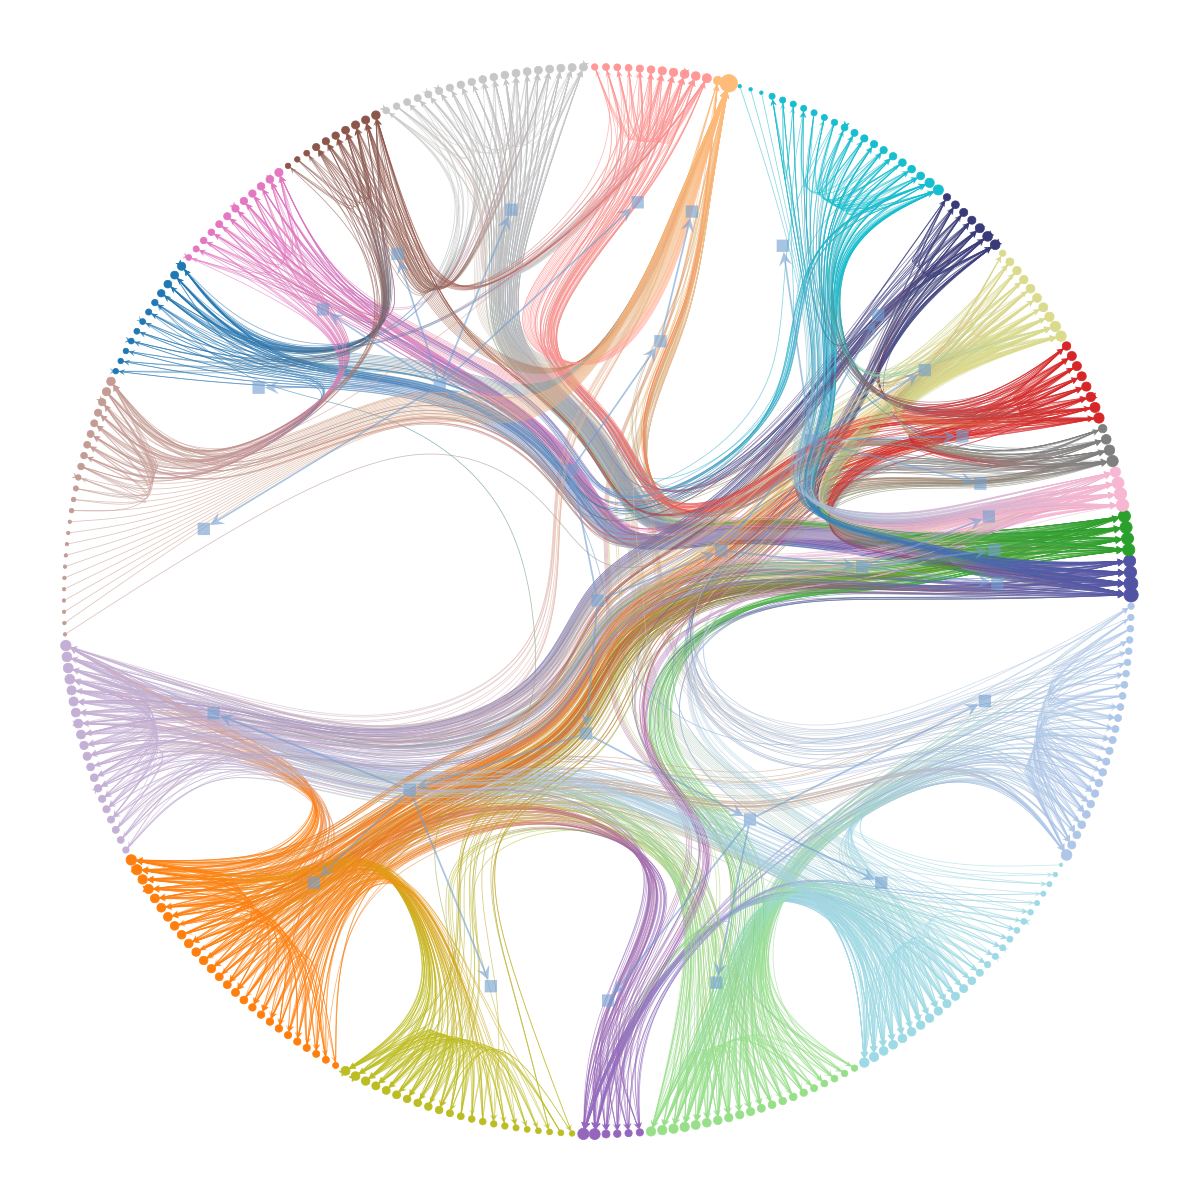

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7c94df82a750, at 0x7c94dcde8790>,
 <GraphView object, directed, with 329 vertices and 328 edges, edges filtered by <EdgePropertyMap object with value type 'bool', for Graph 0x7c94dd631fd0, at 0x7c94dd033450>, vertices filtered by <VertexPropertyMap object with value type 'bool', for Graph 0x7c94dd631fd0, at 0x7c94dd630710>, at 0x7c94dd631fd0>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7c94dd631fd0, at 0x7c94dcf0e290>)

In [44]:
state.draw()

🧹 Cache nettoyé
🎤 5694 publications rap - index propres
🎯 Échantillon de 1000 documents pour tests
📊 Sélection de tous les documents traités
✅ 1000 documents sélectionnés
🔬 Création du modèle de topics rap...
Generating doc ter graph for all
Vocab size: 7630


Processing docs: 100%|██████████| 1000/1000 [00:00<00:00, 19434.36it/s]

Graph set to: graph; kind=docter; column=_tokens__;title,abstract.gt.xz


Loaded: graph; kind=docter; column=_tokens__;title,abstract.gt.xz
<Graph object, undirected, with 8630 vertices and 24958 edges, 2 internal vertex properties, at 0x7c94d662a990>
Vertex property "type" found, using it as pclabel
Starting minimization...
Stored: auto_sashimi/data/rap_clean.parquet.zst/graph; kind=docter; column=_tokens__;title,abstract.gt.xz/blockstate; strategy=['mnbdl']; run=0.json.xz/blockstate; strategy=['mnbdl']; run=0.json.xz
Saved state: blockstate; strategy=['mnbdl']; run=0.json.xz
Loaded: blockstate; strategy=['mnbdl']; run=0.json.xz
<NestedBlockState object, with base <BlockState object with 49 blocks (49 nonempty), degree-corrected, for graph <Graph object, undirected, with 8630 vertices and 24958 edges, 2 internal vertex properties, at 0x7c94dcf5e110>, at 0x7c94d41024d0>, and 5 levels of sizes [(8630, 49), (49, 16), (16, 8), (8, 2), (2, 2)] at 0x7c94d4341dd0>


Doc: 100%|██████████| 1000/1000 [00:00<00:00, 63936.59it/s]


🎤 Visualisation de votre corpus rap :


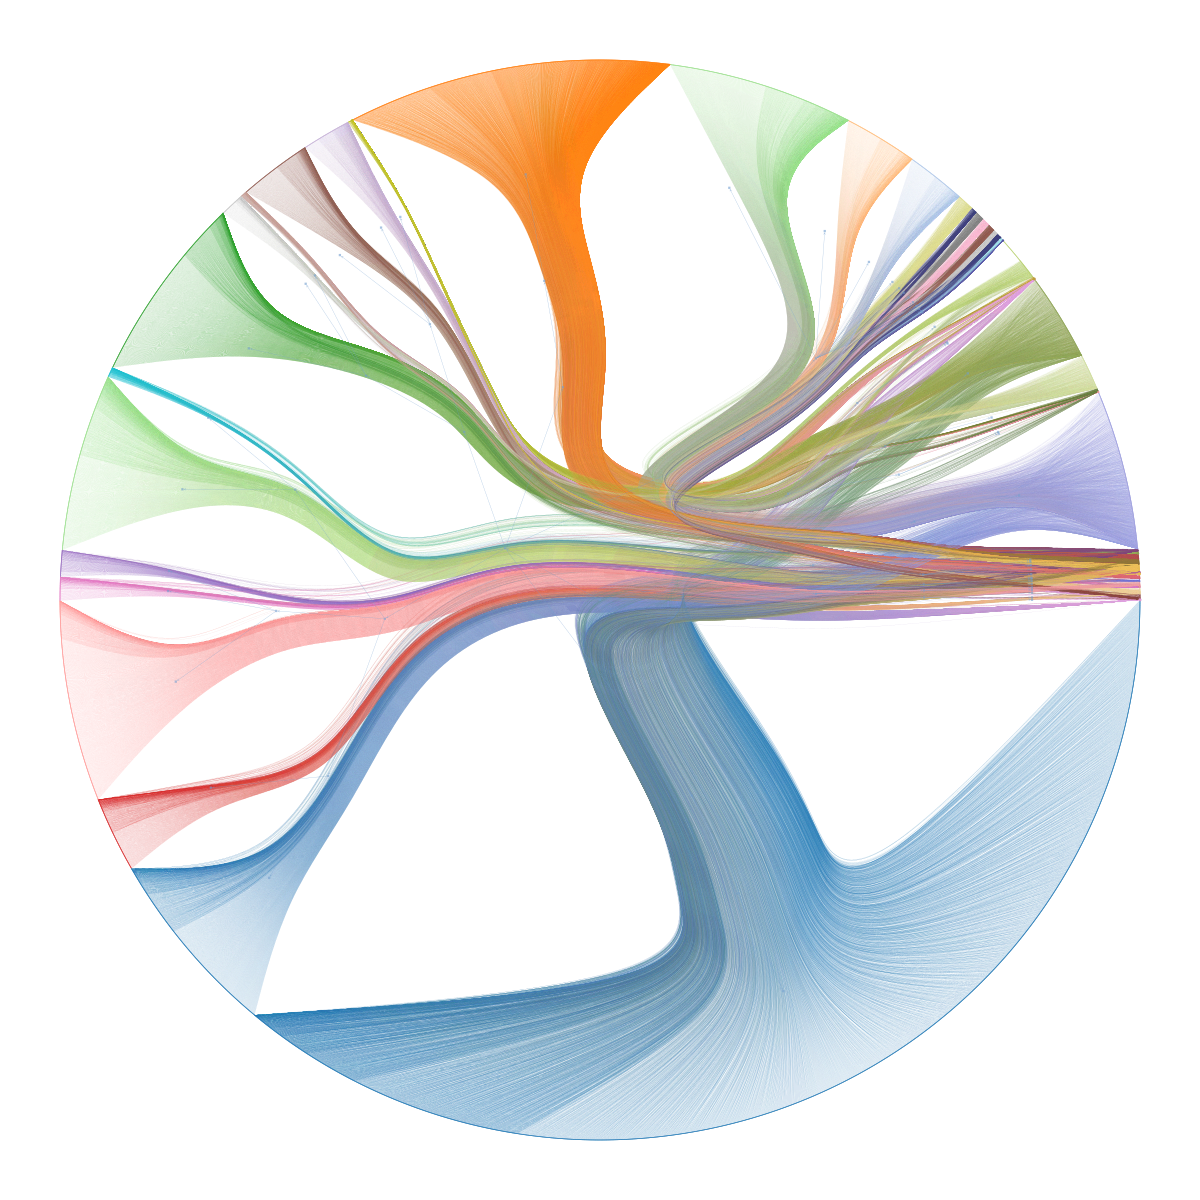

✅ Graph de recherche rap généré avec succès !


In [55]:
# 1. NETTOYER COMPLÈTEMENT LE CACHE
import shutil
import os
if os.path.exists('auto_sashimi'):
    shutil.rmtree('auto_sashimi')
print("🧹 Cache nettoyé")

# 2. CHARGER DONNÉES AVEC INDEX PROPRES
import pandas as pd
import sashimi
import graph_tool.all as gt

df_documents = pd.read_csv('/content/works-2025-06-26T20-54-21.csv', low_memory=False)

# CRITQUE : Reset des index pour éviter les décalages
df_documents = df_documents.reset_index(drop=True)
print(f"🎤 {len(df_documents)} publications rap - index propres")

# 3. ÉCHANTILLON POUR ÉVITER LES ERREURS (optionnel mais plus sûr)
# Prendre un échantillon raisonnable pour commencer
df_sample = df_documents.sample(n=1000, random_state=42).reset_index(drop=True)
print(f"🎯 Échantillon de {len(df_sample)} documents pour tests")

# 4. NOUVEAU CORPUS FRAIS
corpus = sashimi.GraphModels(
    text_sources=['title', 'abstract'],
    col_title='title',
    col_time='publication_year',
    col_authors='authorships.author.display_name',
    col_venue="primary_location.source.display_name",
)

# 5. CHARGEMENT AVEC NOUVEAU NOM
corpus.load_data(df_sample, name='rap_clean')  # Nouveau nom pour éviter conflicts
corpus.process_sources(language='en', filter_first_between_languages=['en', 'fr'])

# 6. SÉLECTION SIMPLE (tous les documents pour éviter les erreurs d'index)
print("📊 Sélection de tous les documents traités")
processed_count = len(corpus.data[corpus.column])
corpus.set_selection([True] * processed_count)  # Sélection explicite
print(f"✅ {processed_count} documents sélectionnés")

# 7. CRÉER LE MODÈLE
print("🔬 Création du modèle de topics rap...")
corpus.load_domain_topic_model()
corpus.register_config()

# 8. 🎨 VOTRE GRAPH RAP !
print("🎤 Visualisation de votre corpus rap :")
corpus.state.draw()

# Version sauvegardée
corpus.state.draw(
    vertex_size=10,
    vertex_font_size=8,
    output_size=(1400, 1000),
    output="rap_research_network.png"
)

print("✅ Graph de recherche rap généré avec succès !")

In [65]:
# Version corrigée pour analyser votre graph rap
if hasattr(corpus, 'state'):
    levels = corpus.state.get_levels()
    base_blocks = levels[0].get_blocks()
    topic_counts = pd.Series(base_blocks.a).value_counts().sort_index()

    print("🎵 VOS THÈMES RAP DÉCOUVERTS :")
    for topic_id, count in topic_counts.items():
        percentage = (count / len(base_blocks.a)) * 100
        print(f"  🎤 Thème {topic_id}: {count} articles ({percentage:.1f}%)")

    # Informations alternatives sur le corpus
    print(f"\n📊 STATISTIQUES DU CORPUS :")
    print(f"  📄 Documents analysés: {len(base_blocks.a)}")
    print(f"  🎯 Thèmes identifiés: {topic_counts.max() + 1}")
    print(f"  📈 Niveaux hiérarchiques: {len(levels)}")

    # Informations sur le graphe
    if hasattr(corpus, 'graph'):
        g = corpus.graph
        print(f"  🔗 Nœuds total: {g.num_vertices()}")
        print(f"  🕸️ Connexions: {g.num_edges()}")

    # Voir quelques exemples de titres par thème
    print(f"\n📚 APERÇU PAR THÈME :")
    for topic_id in range(min(3, len(topic_counts))):  # Max 3 thèmes
        topic_docs = [i for i, x in enumerate(base_blocks.a) if x == topic_id]
        if topic_docs:
            sample_idx = topic_docs[0]  # Premier document de ce thème
            if sample_idx < len(corpus.full_data):
                sample_title = corpus.full_data.iloc[sample_idx]['title']
                print(f"  🎵 Thème {topic_id}: \"{sample_title[:60]}...\"")

# Informations générales sur votre dataset
print(f"\n🎤 VOTRE CORPUS RAP COMPLET :")
print(f"  📊 Total publications: {len(df_sample)}")
print(f"  📅 Années: {df_sample['publication_year'].min()}-{df_sample['publication_year'].max()}")

# Top auteurs dans l'échantillon
if 'authorships.author.display_name' in df_sample.columns:
    authors = df_sample['authorships.author.display_name'].str.split('|').explode()
    top_authors = authors.value_counts().head(5)
    print(f"\n👑 TOP CHERCHEURS RAP (échantillon) :")
    for author, count in top_authors.items():
        if pd.notna(author) and author.strip():
            print(f"  🎓 {author}: {count} publications")

🎵 VOS THÈMES RAP DÉCOUVERTS :
  🎤 Thème 0: 489 articles (5.7%)
  🎤 Thème 1: 3111 articles (36.0%)
  🎤 Thème 2: 153 articles (1.8%)
  🎤 Thème 3: 832 articles (9.6%)
  🎤 Thème 4: 190 articles (2.2%)
  🎤 Thème 5: 486 articles (5.6%)
  🎤 Thème 6: 458 articles (5.3%)
  🎤 Thème 7: 478 articles (5.5%)
  🎤 Thème 8: 195 articles (2.3%)
  🎤 Thème 9: 518 articles (6.0%)
  🎤 Thème 10: 68 articles (0.8%)
  🎤 Thème 11: 127 articles (1.5%)
  🎤 Thème 12: 188 articles (2.2%)
  🎤 Thème 13: 20 articles (0.2%)
  🎤 Thème 14: 17 articles (0.2%)
  🎤 Thème 15: 61 articles (0.7%)
  🎤 Thème 16: 20 articles (0.2%)
  🎤 Thème 17: 24 articles (0.3%)
  🎤 Thème 18: 62 articles (0.7%)
  🎤 Thème 19: 12 articles (0.1%)
  🎤 Thème 20: 13 articles (0.2%)
  🎤 Thème 21: 43 articles (0.5%)
  🎤 Thème 22: 26 articles (0.3%)
  🎤 Thème 23: 8 articles (0.1%)
  🎤 Thème 24: 16 articles (0.2%)
  🎤 Thème 25: 13 articles (0.2%)
  🎤 Thème 26: 2 articles (0.0%)
  🎤 Thème 27: 7 articles (0.1%)
  🎤 Thème 28: 412 articles (4.8%)
  🎤 Thème 2